# HCAA Testing and creation of portfolios


HAY QUE USAR UNA VERSIÓN MODIFICADA DE GET_LEVELS PARA QUE REGRESE EL THRESHOLD (ESTE THRESHOLD HAY QUE REDONDEARLO UN POCO HACIA ABAJO) Y ESE THRESHOLD ES EL QUE HAY QUE USAR EN EL DENDOGRAMA PARA QUE SE COLOREEN CORRECTAMENTE LOS GRUPOS. 

NOTAR QUE EL ENLACE DE WARD PUEDE PRODUCIR VALORES MAYORES A 2 PUES ESTÁ USANDO UNA FUNCIÓN PARA CALCULAR LA DISTANCIA ENTRE CLUSTERS (NO TIENE POR QUE ESTAR DENTRO DEL BOUND DE LA DISTANCIA DE MANTEGNA). SI SE USA OTRO ENLACE EN DONDE LA FUNCIÓN SEA SELECCIONAR LA DISTANCIA MÁXIMA O MÍNIMA ENTRE DOS PUNTOS DEL CLUSTES, ENTONCES LOS BOUNDS DE MANTEGNA SÍ SE TIENEN QUE RESPETAR, Y DE HECHO SÍ SE RESPETAN, COMO SE MUESTRA A CONTINUACIÓN. 




Ideas:
- Calcularles el IPR a los 12 portafolios

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import kneed
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from sklearn.metrics import calinski_harabasz_score
from hcaa_implementation import hcaa_alocation
import rie_estimator
import csestimator
import typing as t
import yfinance
import pickle
import time
import typing as t

## Definition of aux functions

In [2]:
def get_optimal_k_eigen(corr_matrix, N, T):
    eigenvals = np.linalg.eigvals(corr_matrix)
    count = (eigenvals > 1 + 2 * np.sqrt(N / T) + N / T).sum()
    return count

def get_optimal_k_calenski(dataset, bottom_range, top_range, corr_function):
    corr_mat = corr_function(dataset.T)
    D_matrix = np.sqrt(2 * (1 - corr_mat))
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, "ward", optimal_ordering=True)
    indices = []
    for i in range(bottom_range, top_range):
        labels = fcluster(Z, i, criterion="maxclust")
        indices.append(calinski_harabasz_score(dataset.T, labels))
    # pd.Series(indices).plot()
    print(
        kneed.KneeLocator(
            range(bottom_range, top_range),
            indices,
            curve="convex",
            direction="decreasing",
        ).knee
    )
    return kneed.KneeLocator(
        range(bottom_range, top_range), indices, curve="convex", direction="decreasing"
    ).knee


def get_optimal_k_calenski_rie(dataset, bottom_range, top_range, corr_function):
    corr_mat = corr_function(dataset)
    D_matrix = np.sqrt(2 * (1 - corr_mat))
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, "ward", optimal_ordering=True)
    indices = []
    for i in range(bottom_range, top_range):
        labels = fcluster(Z, i, criterion="maxclust")
        indices.append(calinski_harabasz_score(dataset.T, labels))
    print(
        kneed.KneeLocator(
            range(bottom_range, top_range),
            indices,
            curve="convex",
            direction="decreasing",
        ).knee
    )
    return kneed.KneeLocator(
        range(bottom_range, top_range), indices, curve="convex", direction="decreasing"
    ).knee

def get_levels(n_clusters: int, n_filas: int, mat_Z: np.matrix):
    nodos_id = []
    nivel_nodo = []
    filas_Z = mat_Z.shape[0]
    current_bif = mat_Z[-1]
    nodos_id.append(int(current_bif[0]))
    nivel_nodo.append(.5)
    nodos_id.append(int(current_bif[1]))
    nivel_nodo.append(.5)
    current_level = 2
    while(current_level < n_clusters):
        id_cluster = filas_Z+n_filas-current_level
        current_bif = mat_Z[-current_level]
        index_of_id = nodos_id.index(id_cluster)
        new_weight = nivel_nodo[index_of_id] / 2
        del nivel_nodo[index_of_id]
        del nodos_id[index_of_id]
        nodos_id.append(int(current_bif[0]))
        nivel_nodo.append(new_weight)
        nodos_id.append(int(current_bif[1]))
        nivel_nodo.append(new_weight)
        current_level += 1
    return(nodos_id, nivel_nodo)

## Reading and selecting data

In [3]:
precios_americano = pd.read_csv(
    "./sp_500_original_clean.csv",
    index_col="Date",
    parse_dates=True,
)

precios_europeo = pd.read_csv(
    "./european_market_original_clean.csv",
    index_col="Date",
    parse_dates=True,
)

retornos_american = (np.log(precios_americano) - np.log(precios_americano.shift(1))).iloc[1:]
retornos_europeo = (np.log(precios_europeo) - np.log(precios_europeo.shift(1))).iloc[1:]


Determinación de la última ventana de tiempo para ambos mercados

In [4]:
ultima_ventana_american = retornos_american[retornos_american.shape[0] - (retornos_american.shape[1]*2):]
ultima_ventana_european = retornos_europeo[retornos_europeo.shape[0] - (retornos_europeo.shape[1]*2):]

Los periodos comprendidos entre las ventanas son los siguientes:

Mercado americano: 2018-05-09 a 2021-12-30

Mercado europeo: 2019-10-17 a 2021-12-10

Reviso que el ratio óptimo para el RIE se mantenga, notando que sea de 1/2:

In [5]:
print(ultima_ventana_european.shape[1]/ultima_ventana_european.shape[0])
print(ultima_ventana_american.shape[1]/ultima_ventana_american.shape[0])

0.5
0.5


## Determinación de número óptimo de grupos

### Valores Propios

In [6]:
rie_estimator_american = rie_estimator.get_rie(ultima_ventana_american, True, True)
pearson_estimator_american = np.corrcoef(ultima_ventana_american.values.T)
eca_estimator_american = csestimator.get_shrinkage_est(ultima_ventana_american, alpha = 0.5)

k_optimal_eigen_american_rie = get_optimal_k_eigen(rie_estimator_american, ultima_ventana_american.shape[0], ultima_ventana_american.shape[1])
k_optimal_eigen_american_pearson = get_optimal_k_eigen(pearson_estimator_american, ultima_ventana_american.shape[0], ultima_ventana_american.shape[1])
k_optimal_eigen_american_eca = get_optimal_k_eigen(eca_estimator_american, ultima_ventana_american.shape[0], ultima_ventana_american.shape[1])

print('MERCADO AMERICANO')
print(k_optimal_eigen_american_rie)
print(k_optimal_eigen_american_pearson)
print(k_optimal_eigen_american_eca)


MERCADO AMERICANO
6
5
9


In [7]:
rie_estimator_european = rie_estimator.get_rie(ultima_ventana_european, False, True)
pearson_estimator_european = np.corrcoef(ultima_ventana_european.values.T)
eca_estimator_european = csestimator.get_shrinkage_est(ultima_ventana_european, alpha = 0.5)

k_optimal_eigen_european_rie = get_optimal_k_eigen(rie_estimator_european, ultima_ventana_european.shape[0], ultima_ventana_european.shape[1])
k_optimal_eigen_european_pearson = get_optimal_k_eigen(pearson_estimator_european, ultima_ventana_european.shape[0], ultima_ventana_european.shape[1])
k_optimal_eigen_european_eca = get_optimal_k_eigen(eca_estimator_european, ultima_ventana_european.shape[0], ultima_ventana_european.shape[1])

print('MERCADO EUROPEO')
print(k_optimal_eigen_european_rie)
print(k_optimal_eigen_european_pearson)
print(k_optimal_eigen_european_eca)

MERCADO EUROPEO
3
3
4


### Calenski

In [8]:
k_optimal_calenski_american_rie = get_optimal_k_calenski_rie(ultima_ventana_american, 2, 50, rie_estimator.get_rie)
k_optimal_calenski_american_pearson = get_optimal_k_calenski(ultima_ventana_american, 2, 50, np.corrcoef)
k_optimal_calenski_american_eca = get_optimal_k_calenski(ultima_ventana_american, 2, 50, np.corrcoef)

14
6
6


In [9]:
k_optimal_calenski_european_rie = get_optimal_k_calenski_rie(ultima_ventana_european, 2, 50, rie_estimator.get_rie)
k_optimal_calenski_european_pearson = get_optimal_k_calenski(ultima_ventana_european, 2, 50, np.corrcoef)
k_optimal_calenski_european_eca = get_optimal_k_calenski(ultima_ventana_european, 2, 50, np.corrcoef)

10
8
8


## DENDOGRAM

## Mercado Americano

In [25]:


def get_levels(n_clusters: int, n_filas: int, mat_Z: np.matrix):

    '''
    función modificada de get_levels para poder obtener a partir de cuál fue la última distancia para la que se obtuvo la última 
    separación de un cluster. Esto sirve para poder colorear los grupos de los dendogramas.
    '''
    nodos_id = []
    nivel_nodo = []
    filas_Z = mat_Z.shape[0]
    current_bif = mat_Z[-1]
    nodos_id.append(int(current_bif[0]))
    nivel_nodo.append(.5)
    nodos_id.append(int(current_bif[1]))
    nivel_nodo.append(.5)
    current_level = 2
    while(current_level < n_clusters):
        id_cluster = filas_Z+n_filas-current_level
        current_bif = mat_Z[-current_level]
        index_of_id = nodos_id.index(id_cluster)
        new_weight = nivel_nodo[index_of_id] / 2
        del nivel_nodo[index_of_id]
        del nodos_id[index_of_id]
        nodos_id.append(int(current_bif[0]))
        nivel_nodo.append(new_weight)
        nodos_id.append(int(current_bif[1]))
        nivel_nodo.append(new_weight)
        current_level += 1
    distance_threshold = current_bif[2] - 0.000001
    return(nodos_id, nivel_nodo, distance_threshold)

def hacer_dendograma(data_set: pd.DataFrame, corr_est_func: t.Callable, link_name: str, num_grupos: int) -> dict[str, t.Any]:
    '''
    Función auxiliar para poder obtener el dendograma de una asignación particular, tomando en consideración el número 
    de grupos (para poder colorear cada grupo). Requiere especificar un enlace para la creación de los grupos, así como
    la función que se va a usar para determinar la correlación entre los activos. 
    '''
    E_matrix = corr_est_func(data_set)
    D_matrix = np.sqrt(2*(1- E_matrix))
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, link_name, optimal_ordering = True)
    plt.figure(figsize=(35, 15))
    plt.xlabel('Clave de Pizarra del Activo')
    plt.ylabel('Distancia del enlace de Ward')
    _, _, distancia = get_levels(num_grupos, data_set.shape[1], Z)
    dn = dendrogram(Z, color_threshold= distancia, labels=data_set.columns.to_numpy())
    
    return dn 


### RIE

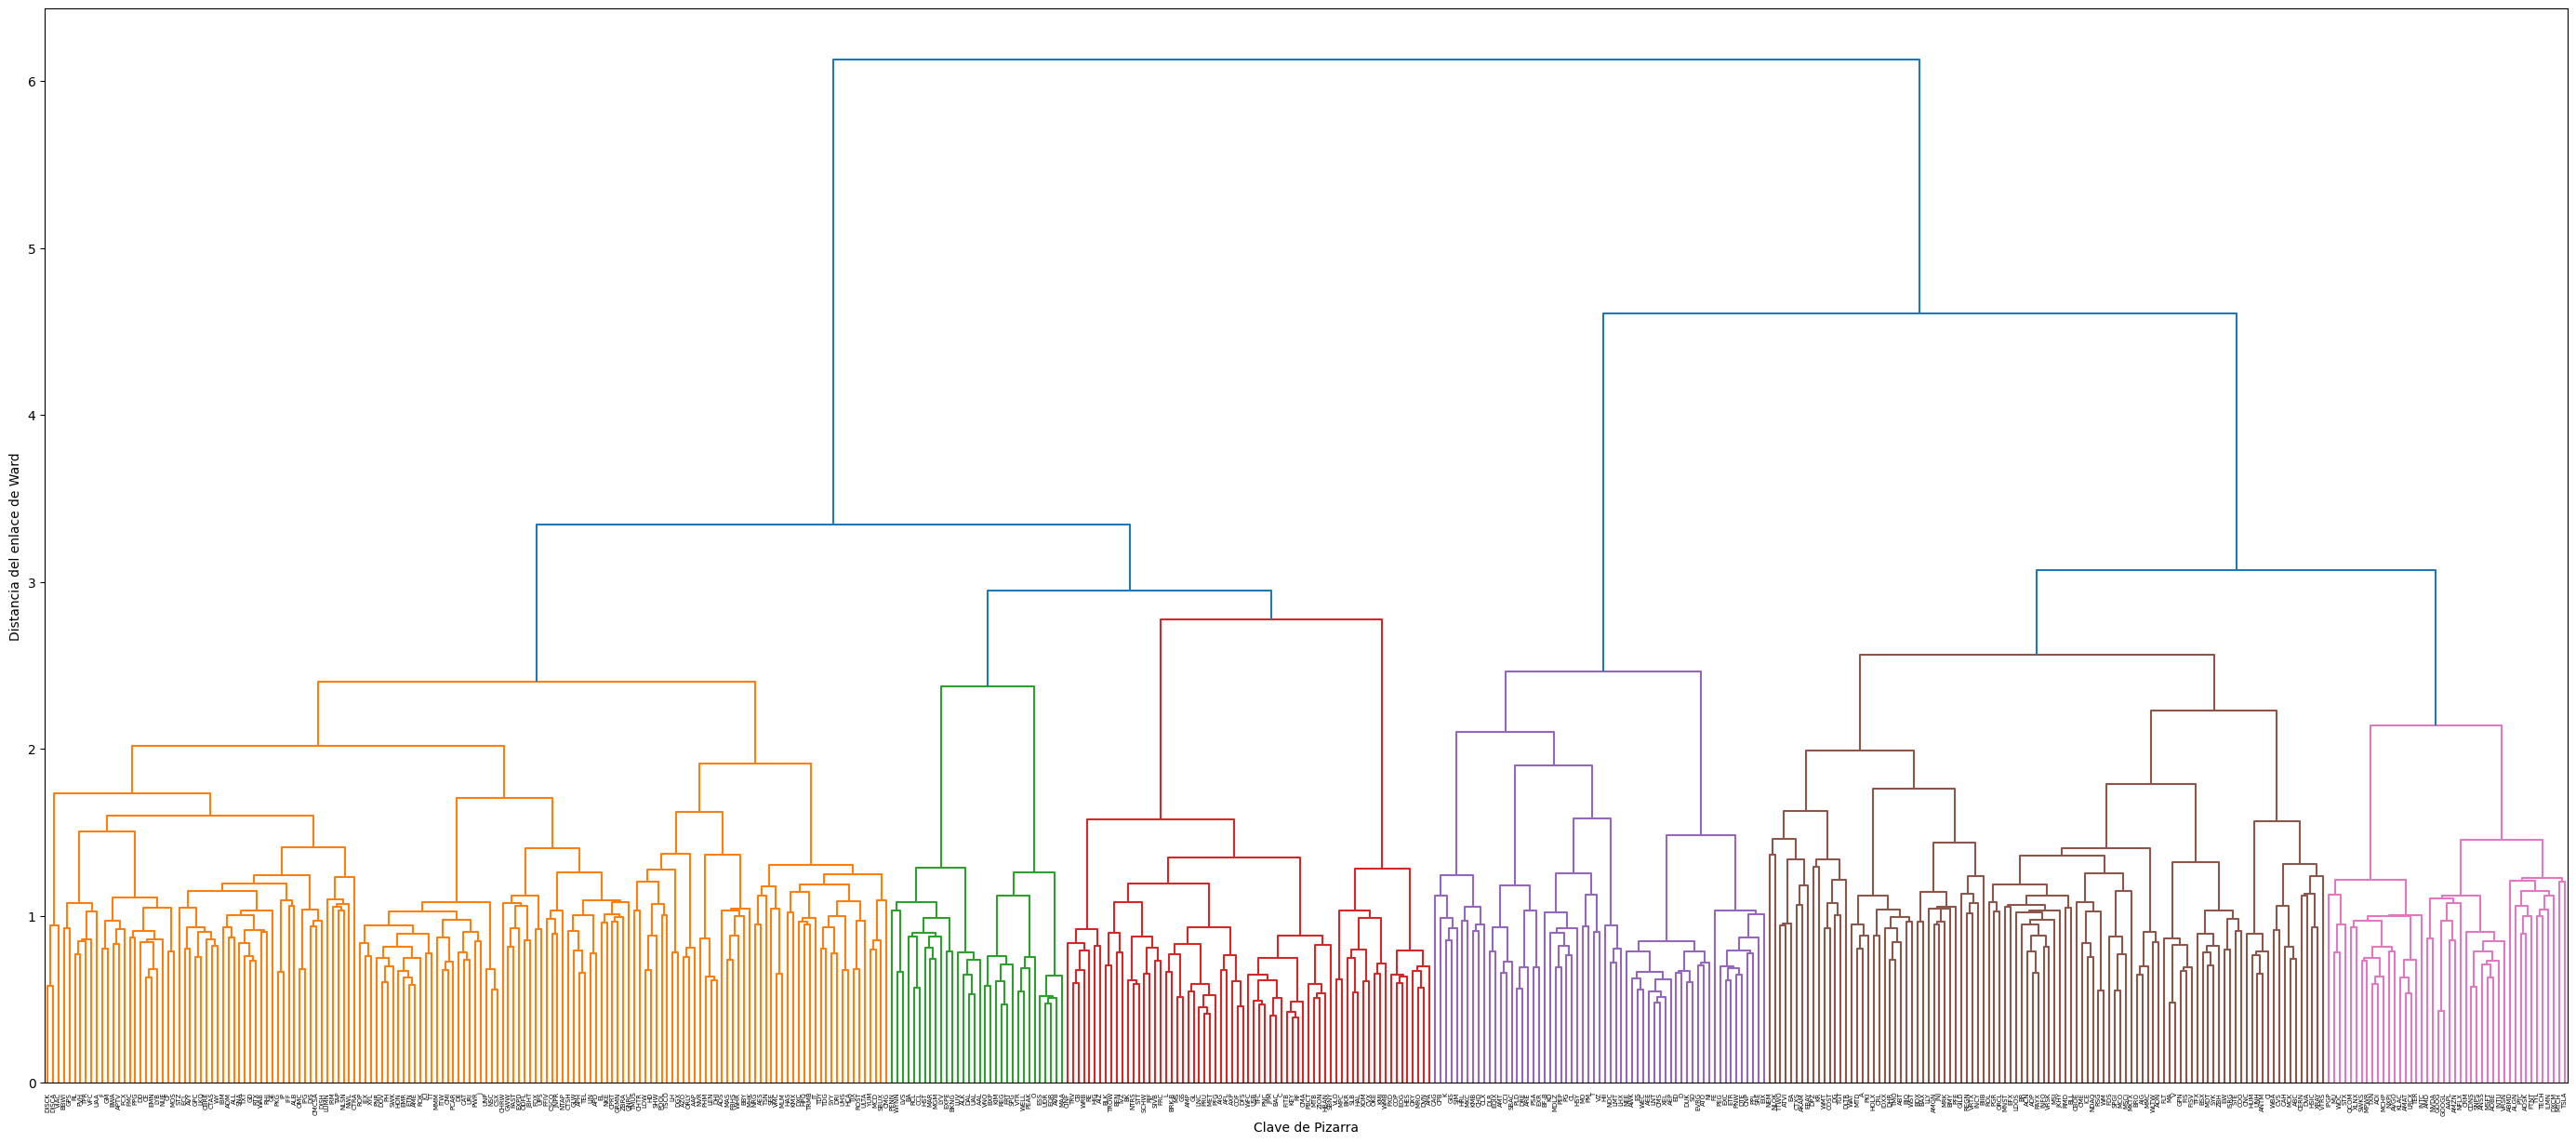

In [36]:
hacer_dendograma(ultima_ventana_american, rie_estimator.get_rie, 'ward', k_optimal_eigen_american_rie);

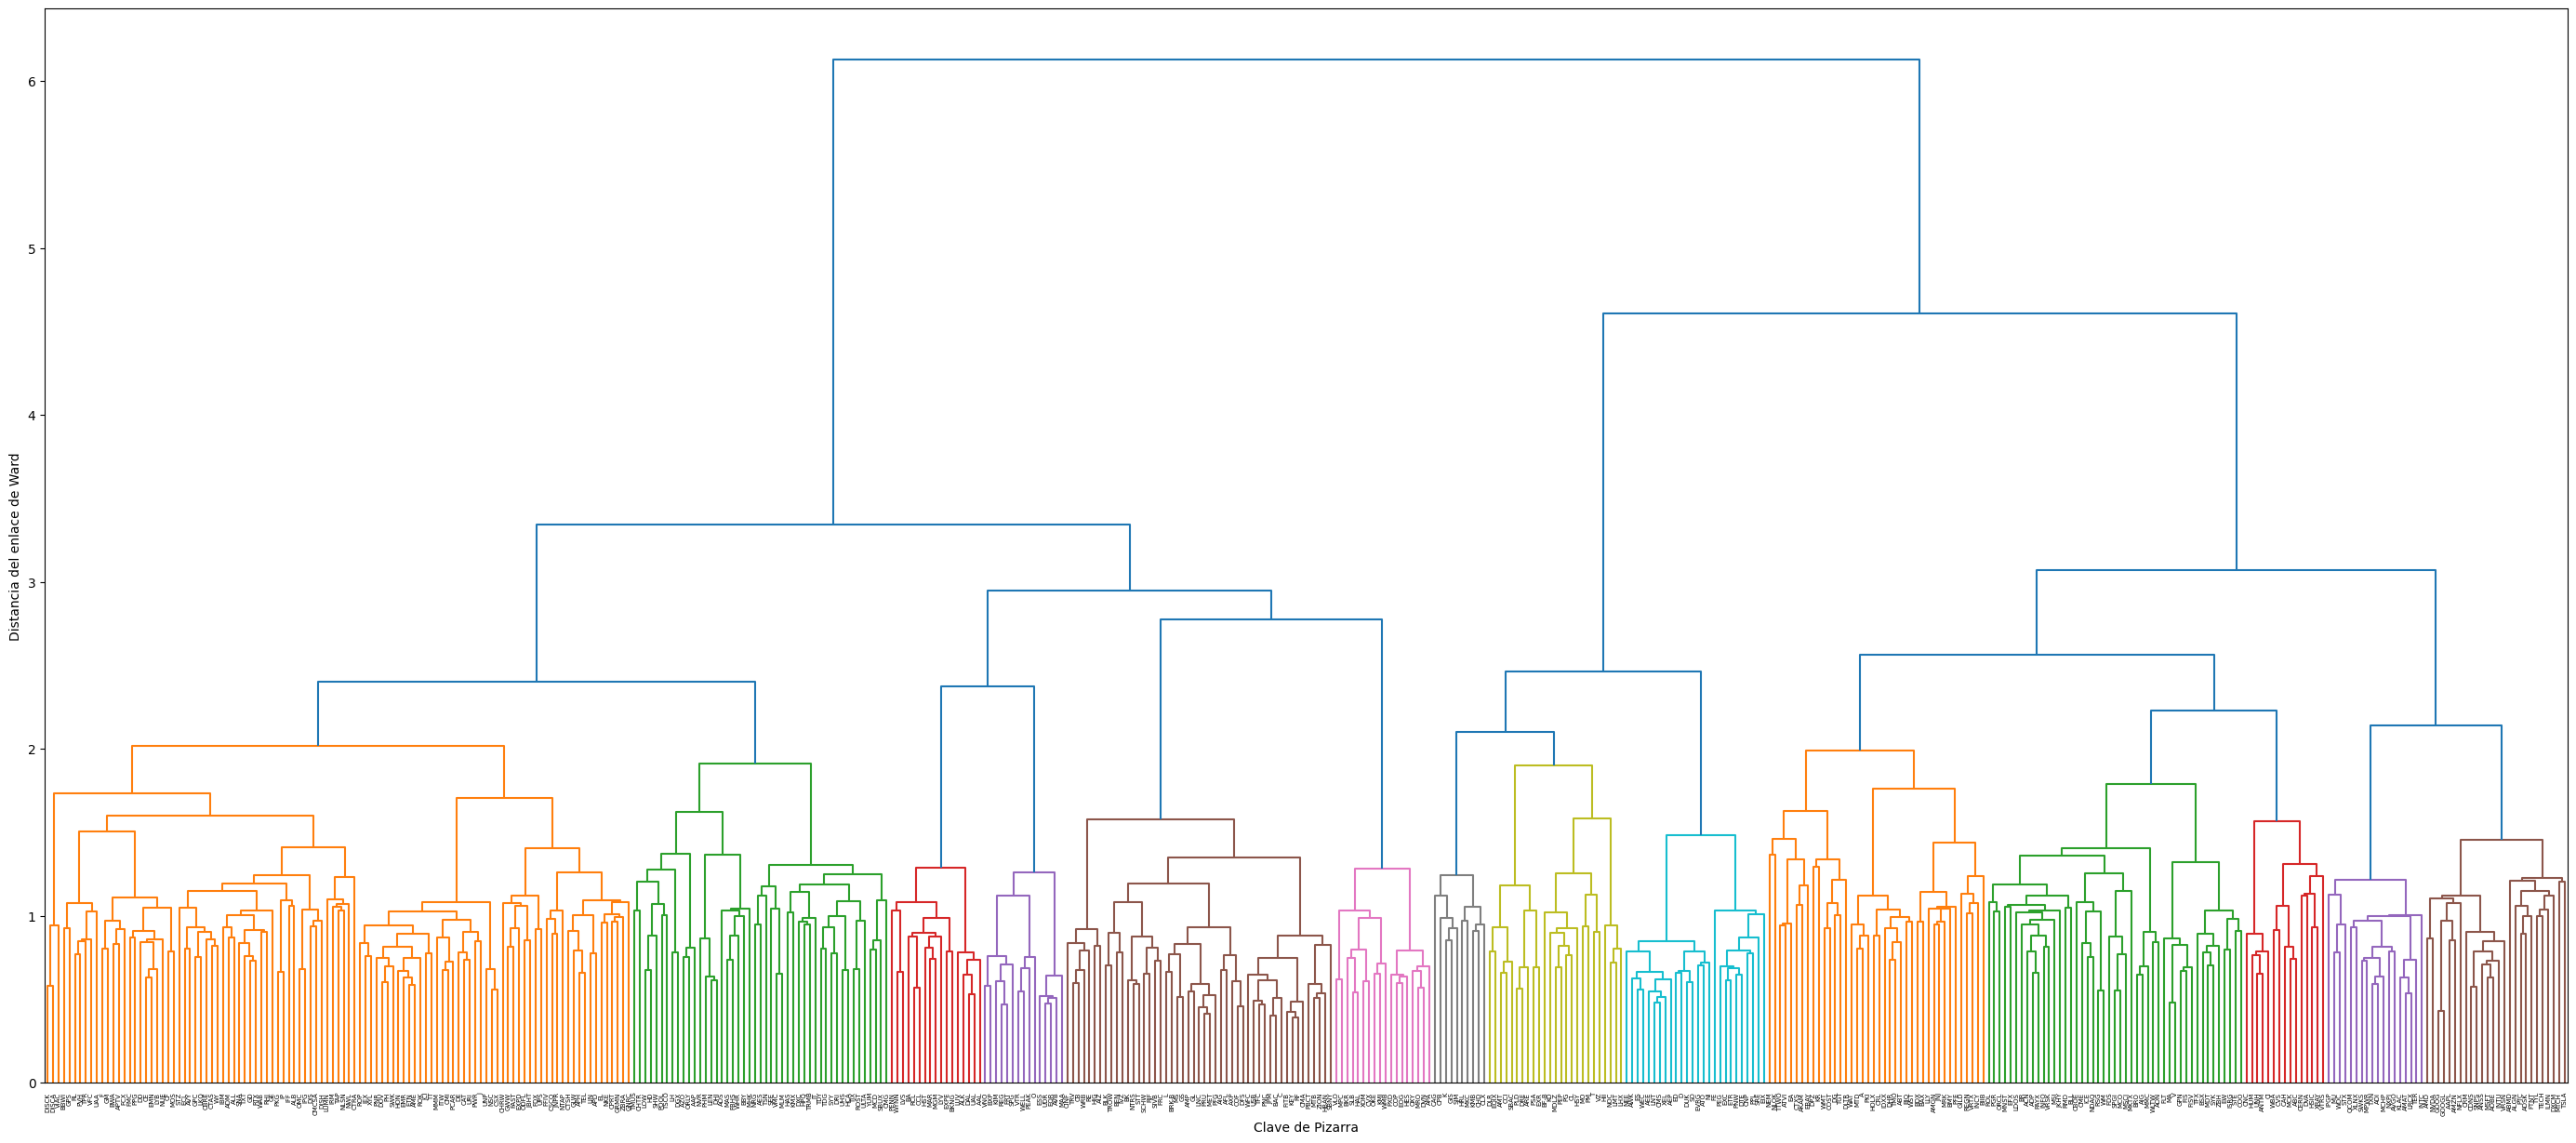

In [37]:
#[TESIS]
hacer_dendograma(ultima_ventana_american, rie_estimator.get_rie, 'ward', k_optimal_calenski_american_rie);

### ECA

In [38]:
def wrapper_eca(X, alpha=0.5):
    '''Funcion auxiliar para poder llamar el estimador ECA de forma directa sin tener que pasar un parámetro alpha
    En este caso se llama por default con alpha 0.5 pero puede ser modificado'''
    return csestimator.get_shrinkage_est(X, alpha)

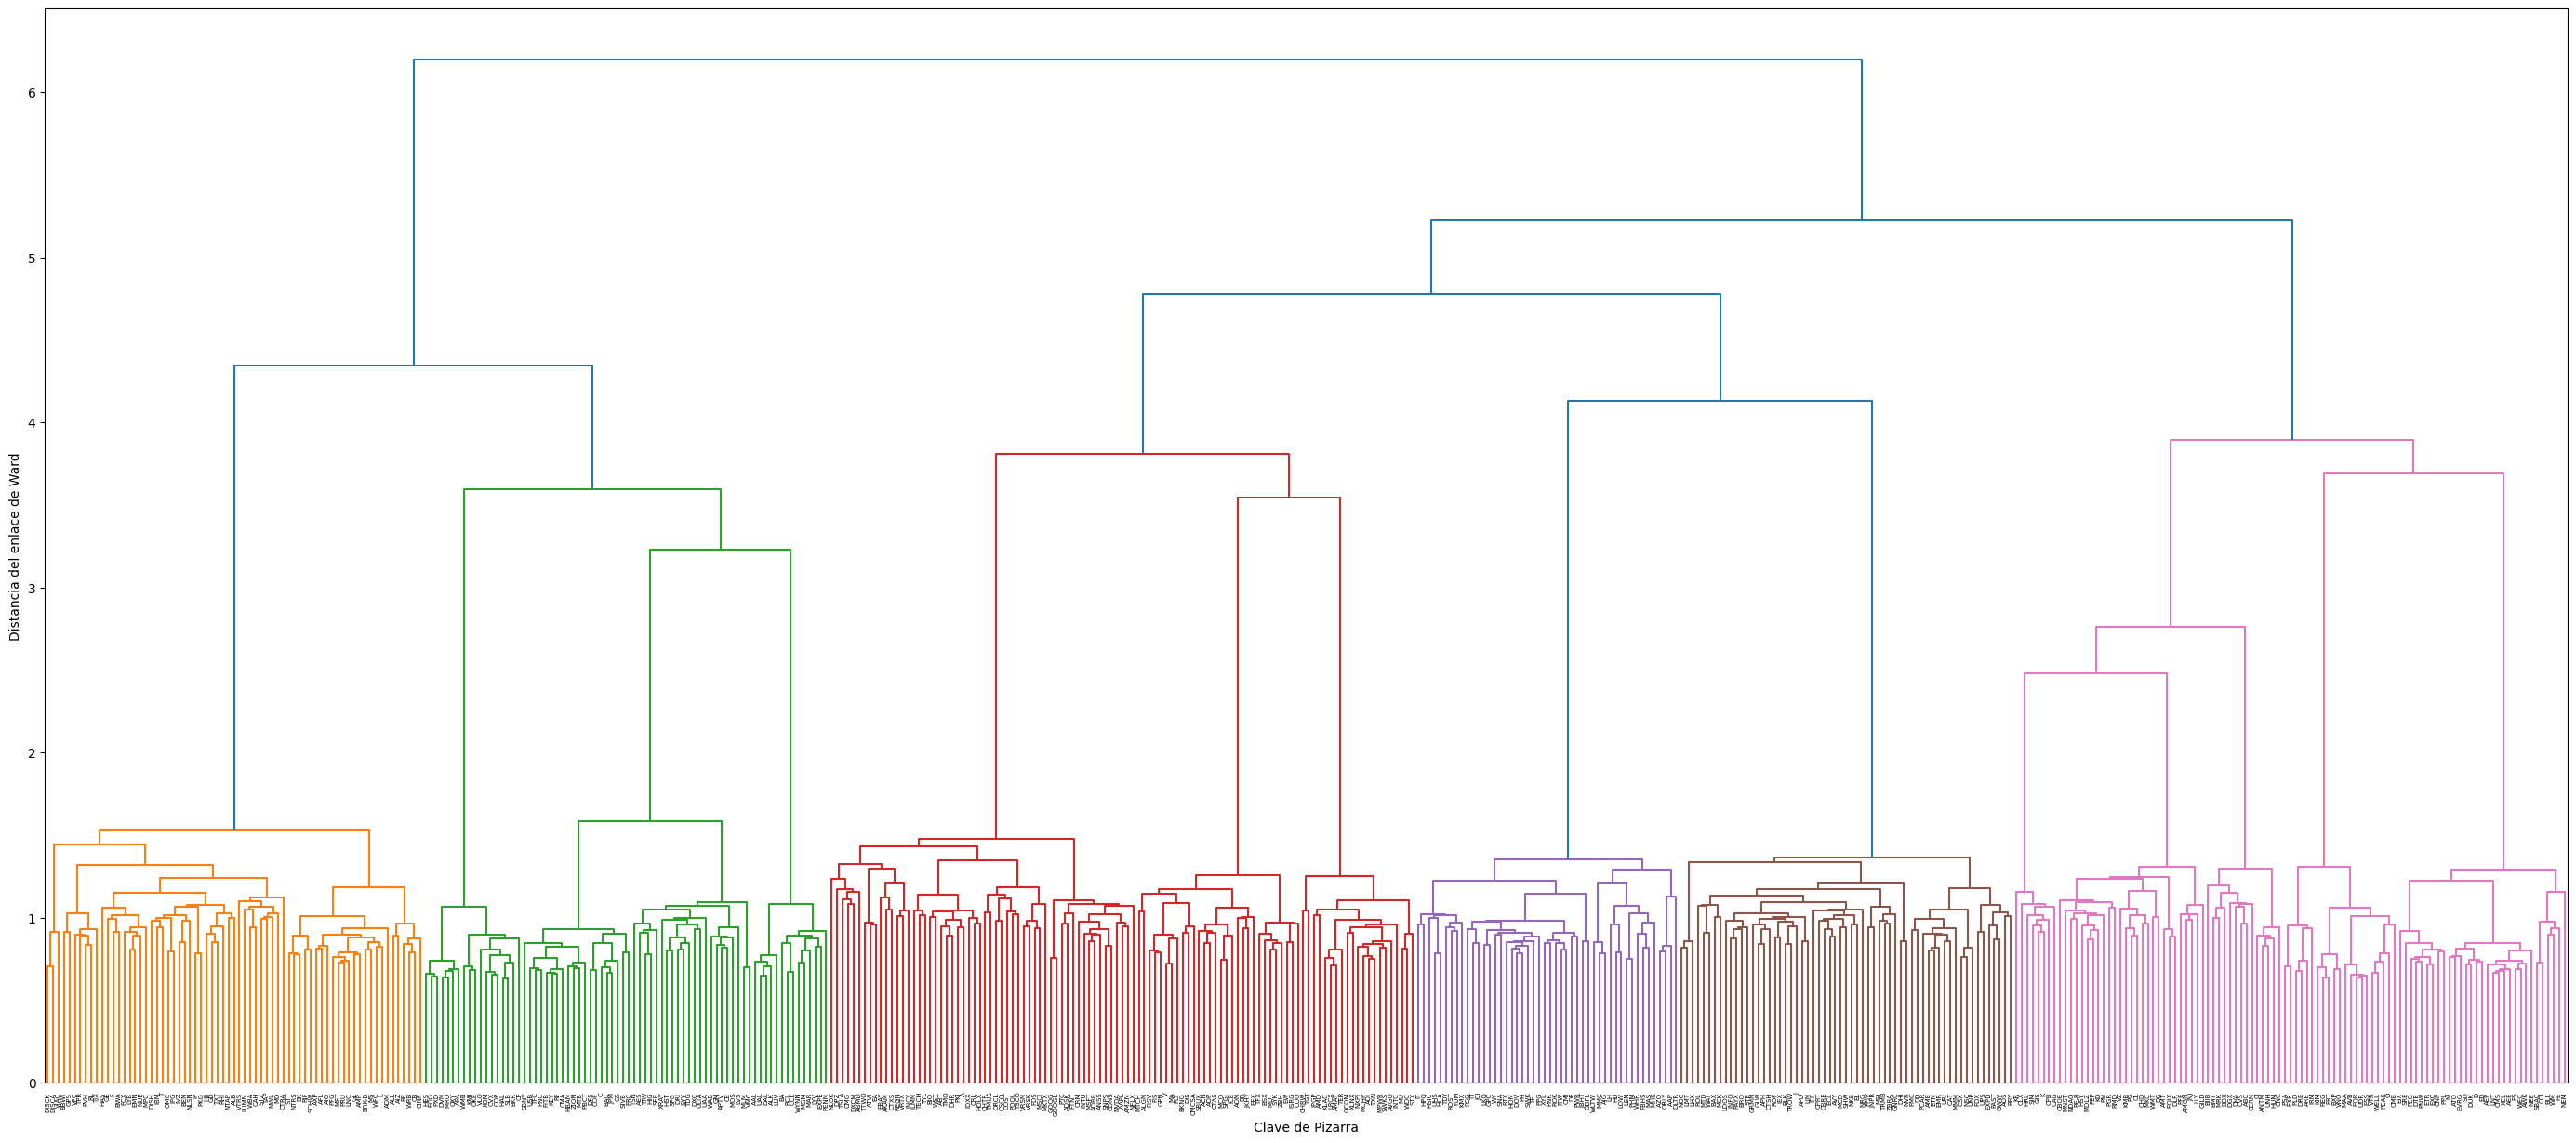

In [39]:
#[TESIS]
hacer_dendograma(ultima_ventana_american, wrapper_eca, 'ward', k_optimal_calenski_american_eca);

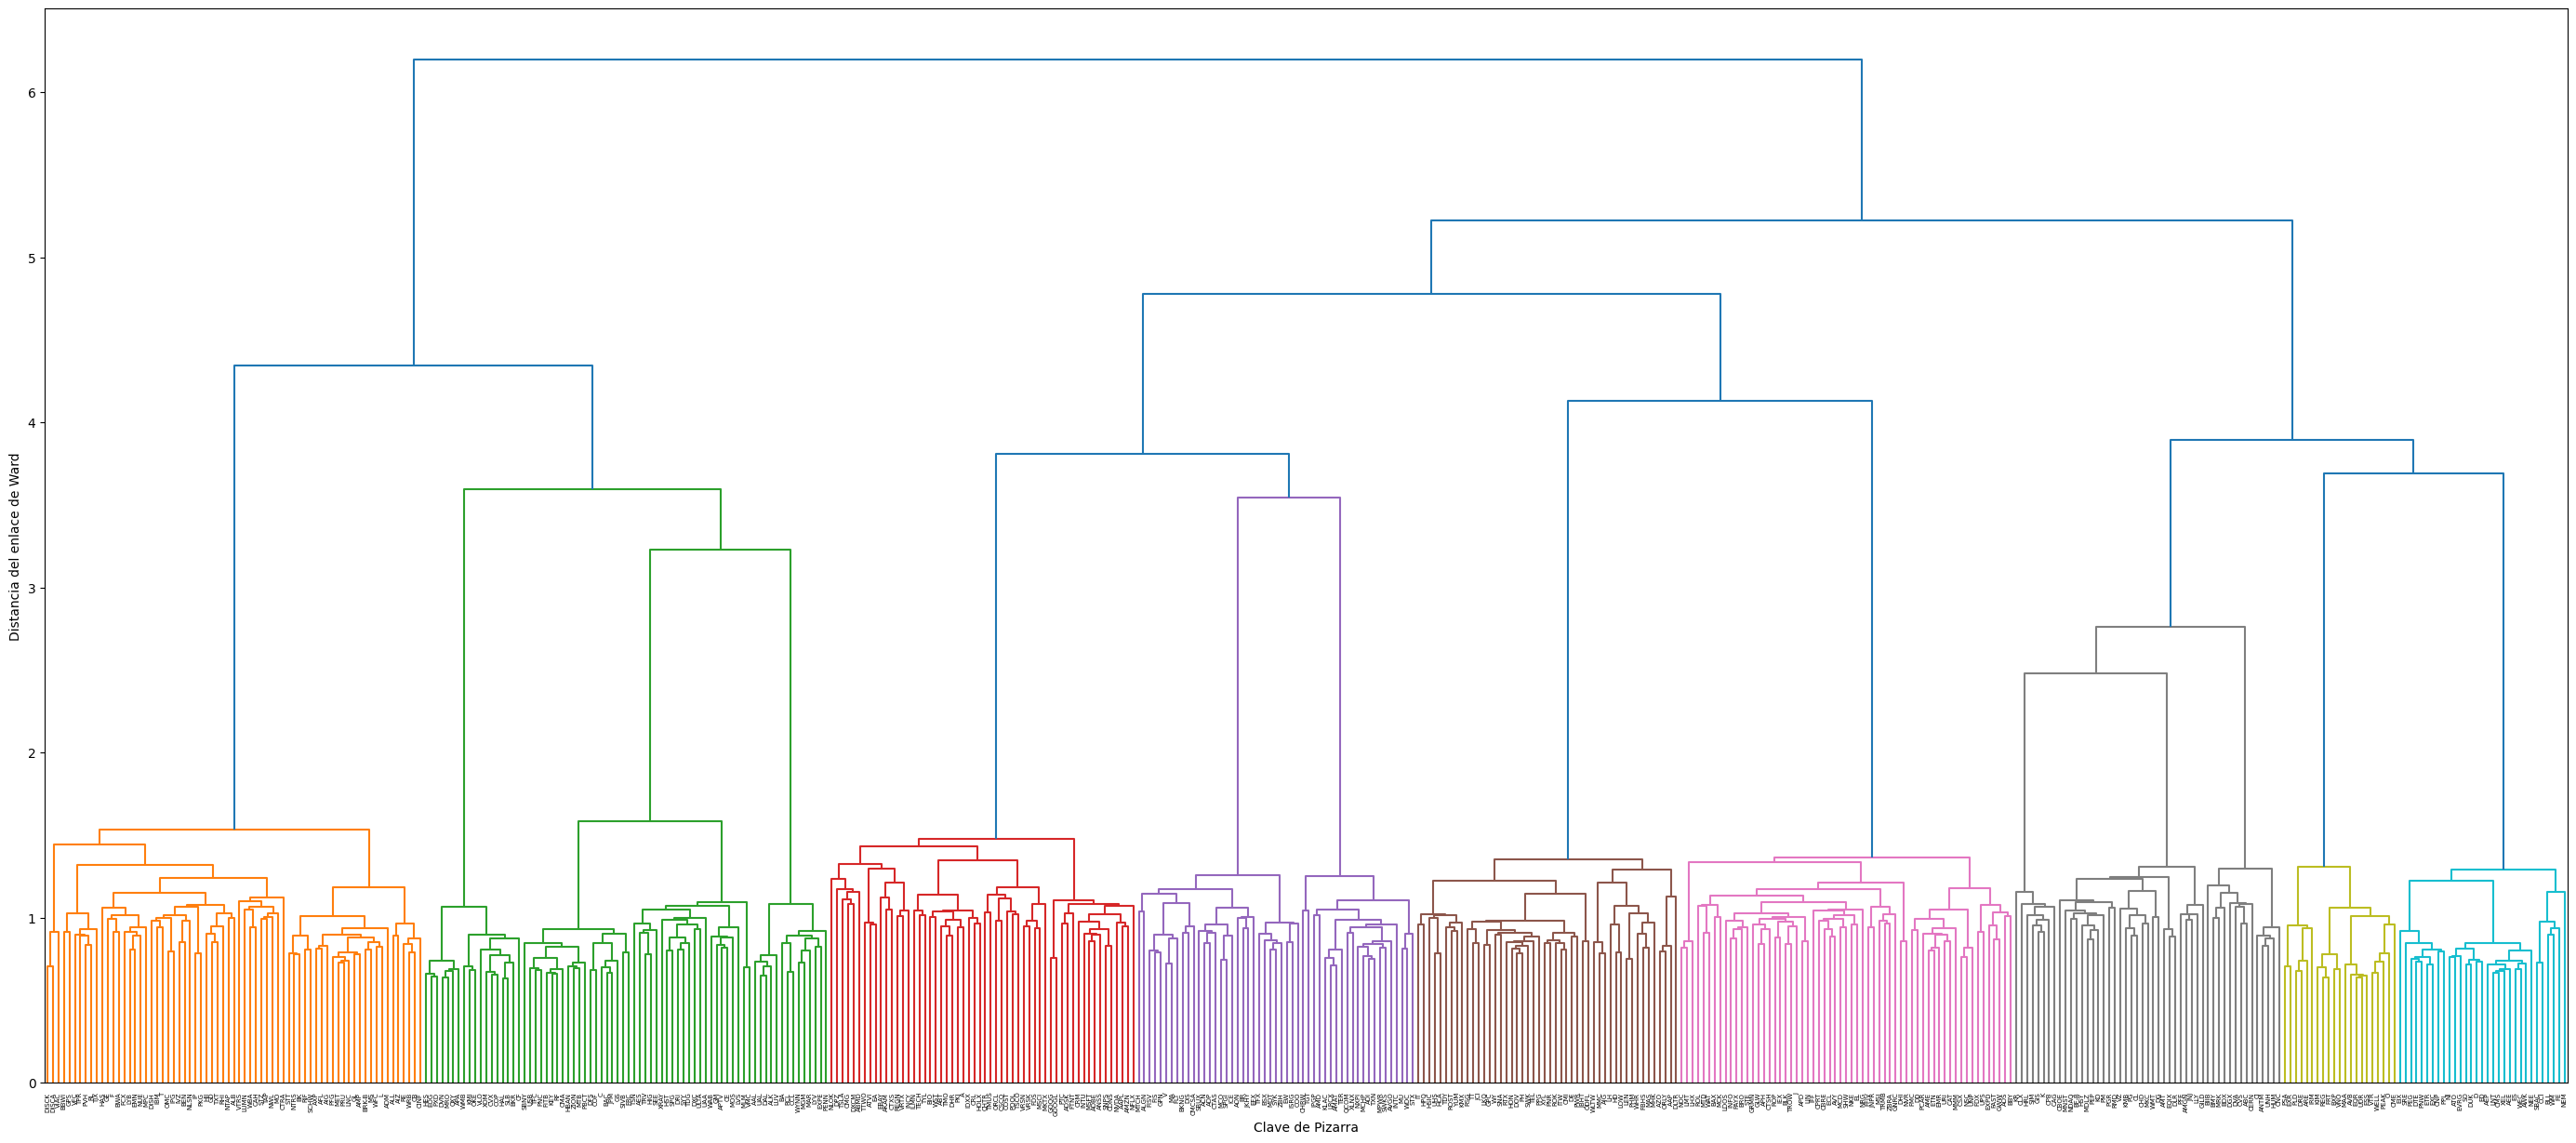

In [40]:
hacer_dendograma(ultima_ventana_american, wrapper_eca, 'ward', k_optimal_eigen_american_eca);

### PEARSON

In [41]:
def wrapper_pearson(X):
    return np.corrcoef(X.T)

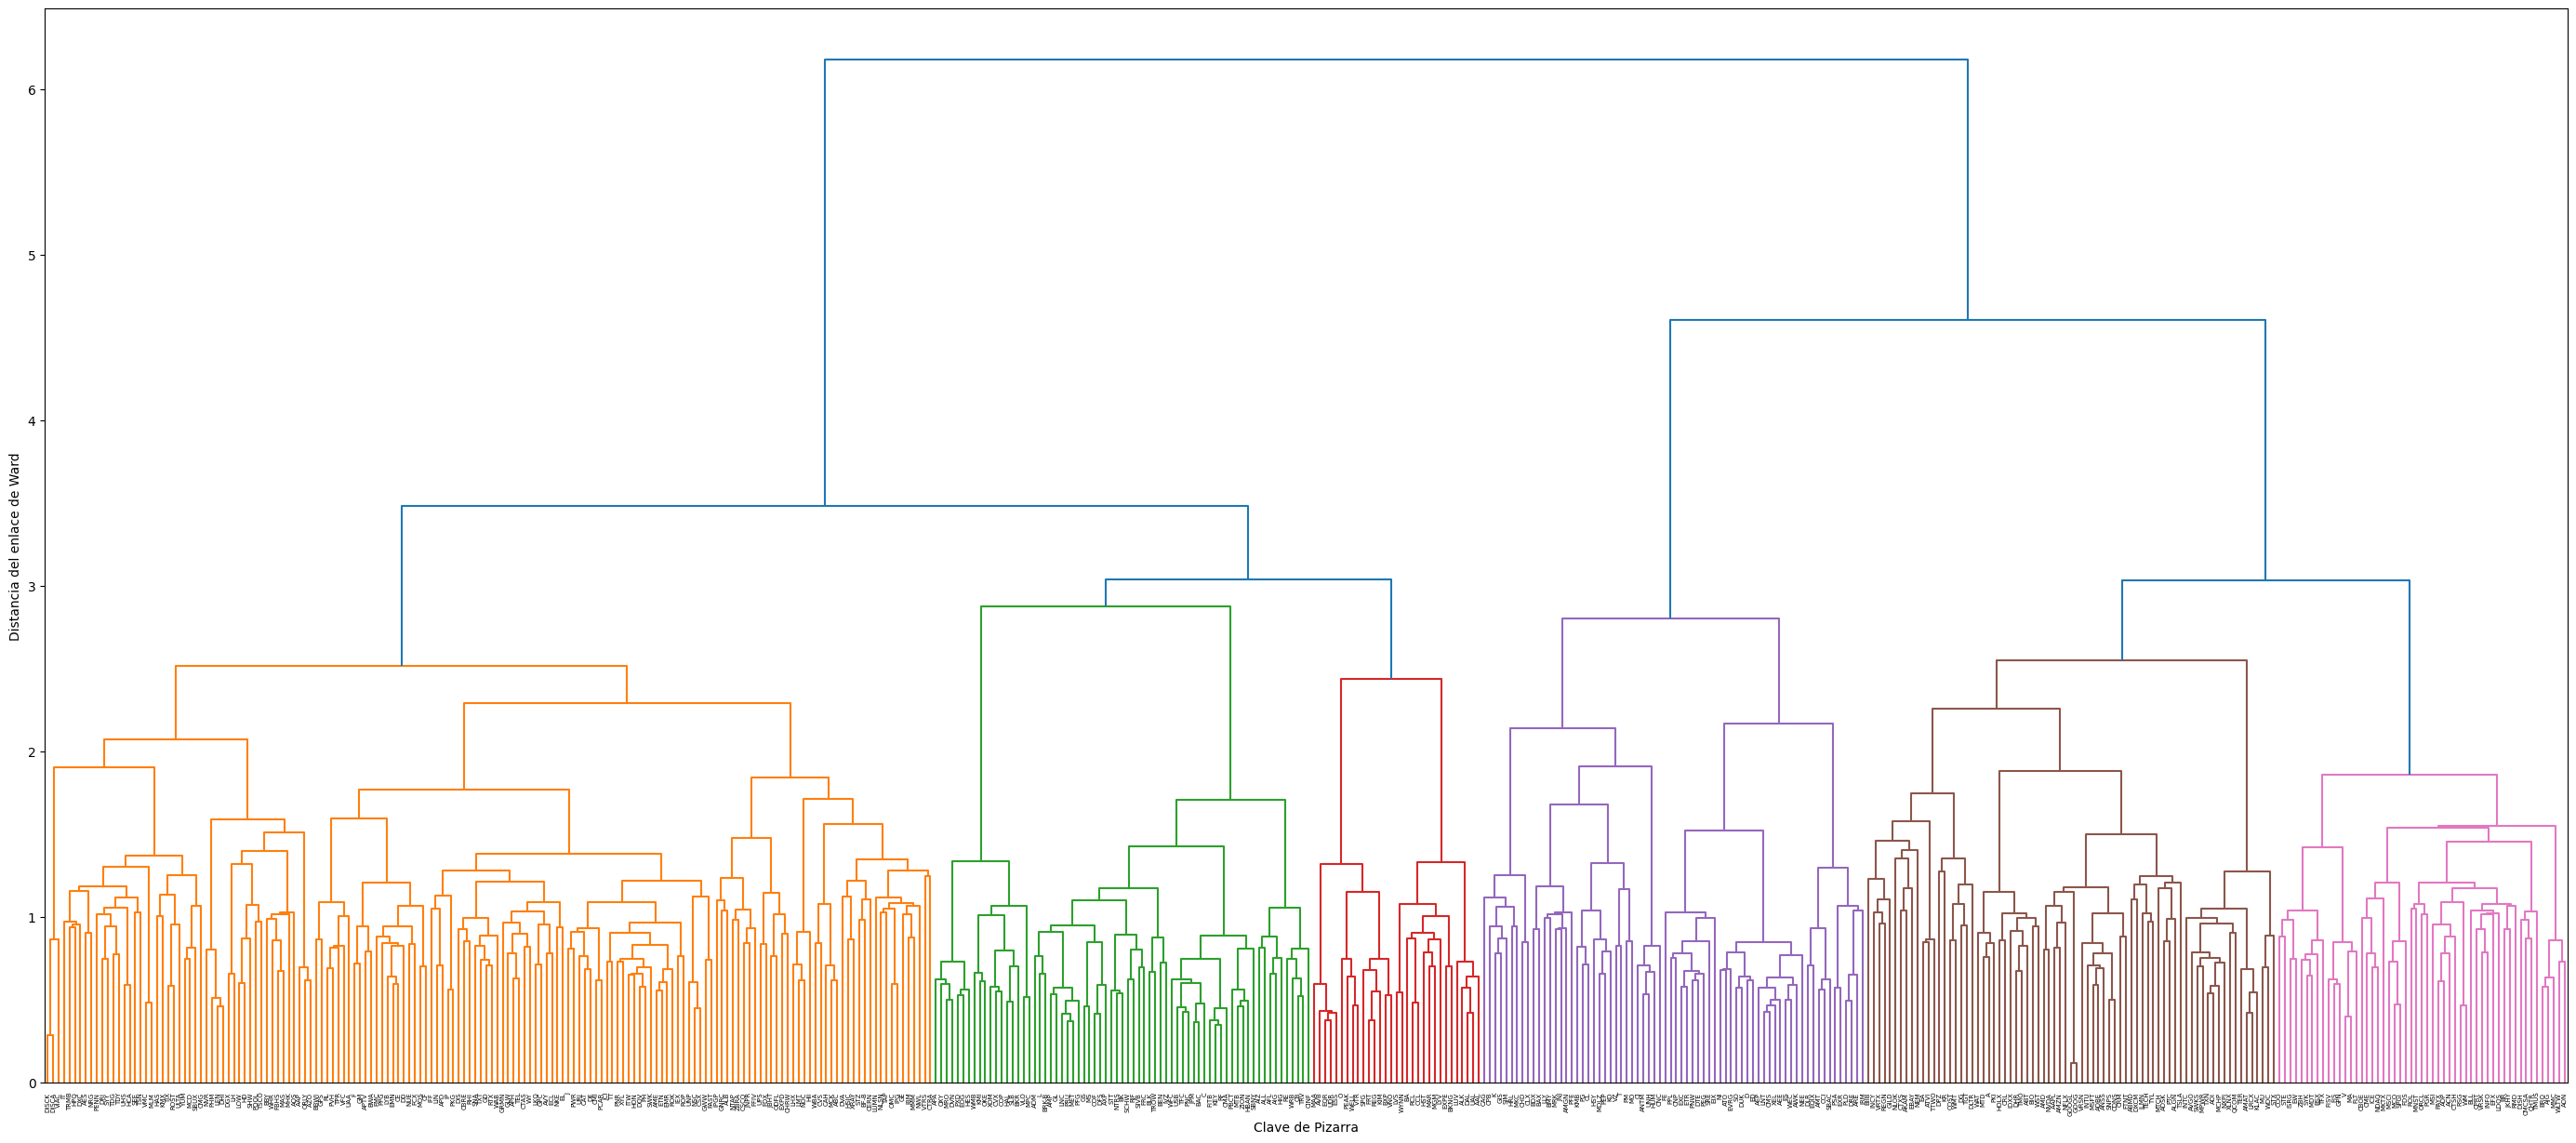

In [42]:
hacer_dendograma(ultima_ventana_american, wrapper_pearson, 'ward', k_optimal_calenski_american_pearson);

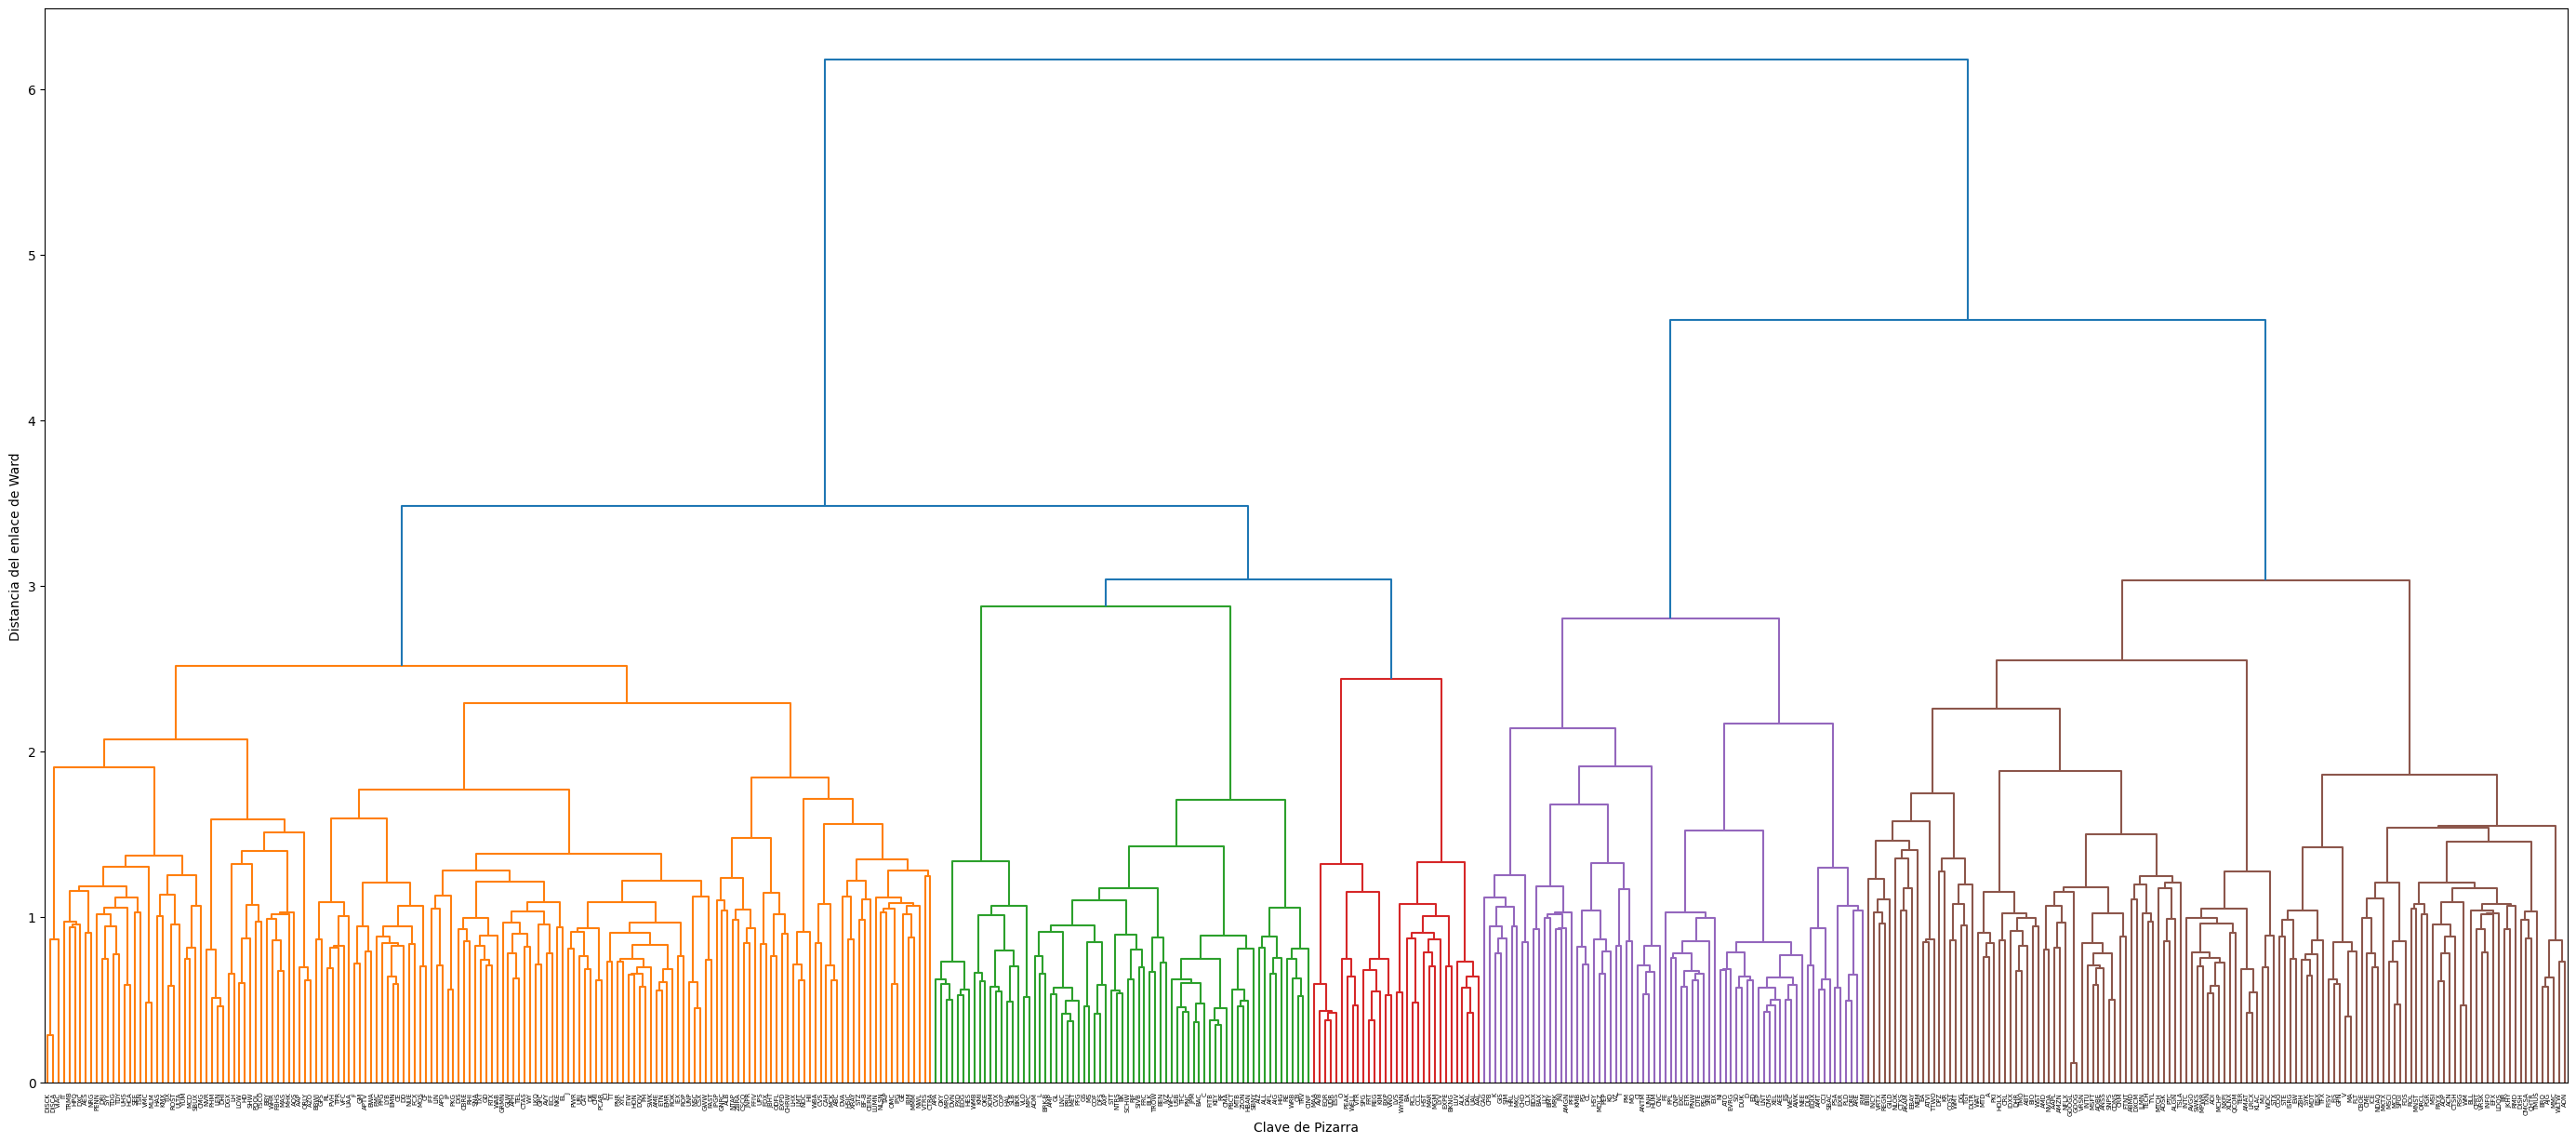

In [43]:
hacer_dendograma(ultima_ventana_american, wrapper_pearson, 'ward', k_optimal_eigen_american_pearson);

## MERCADO EUROPEO

## RIE

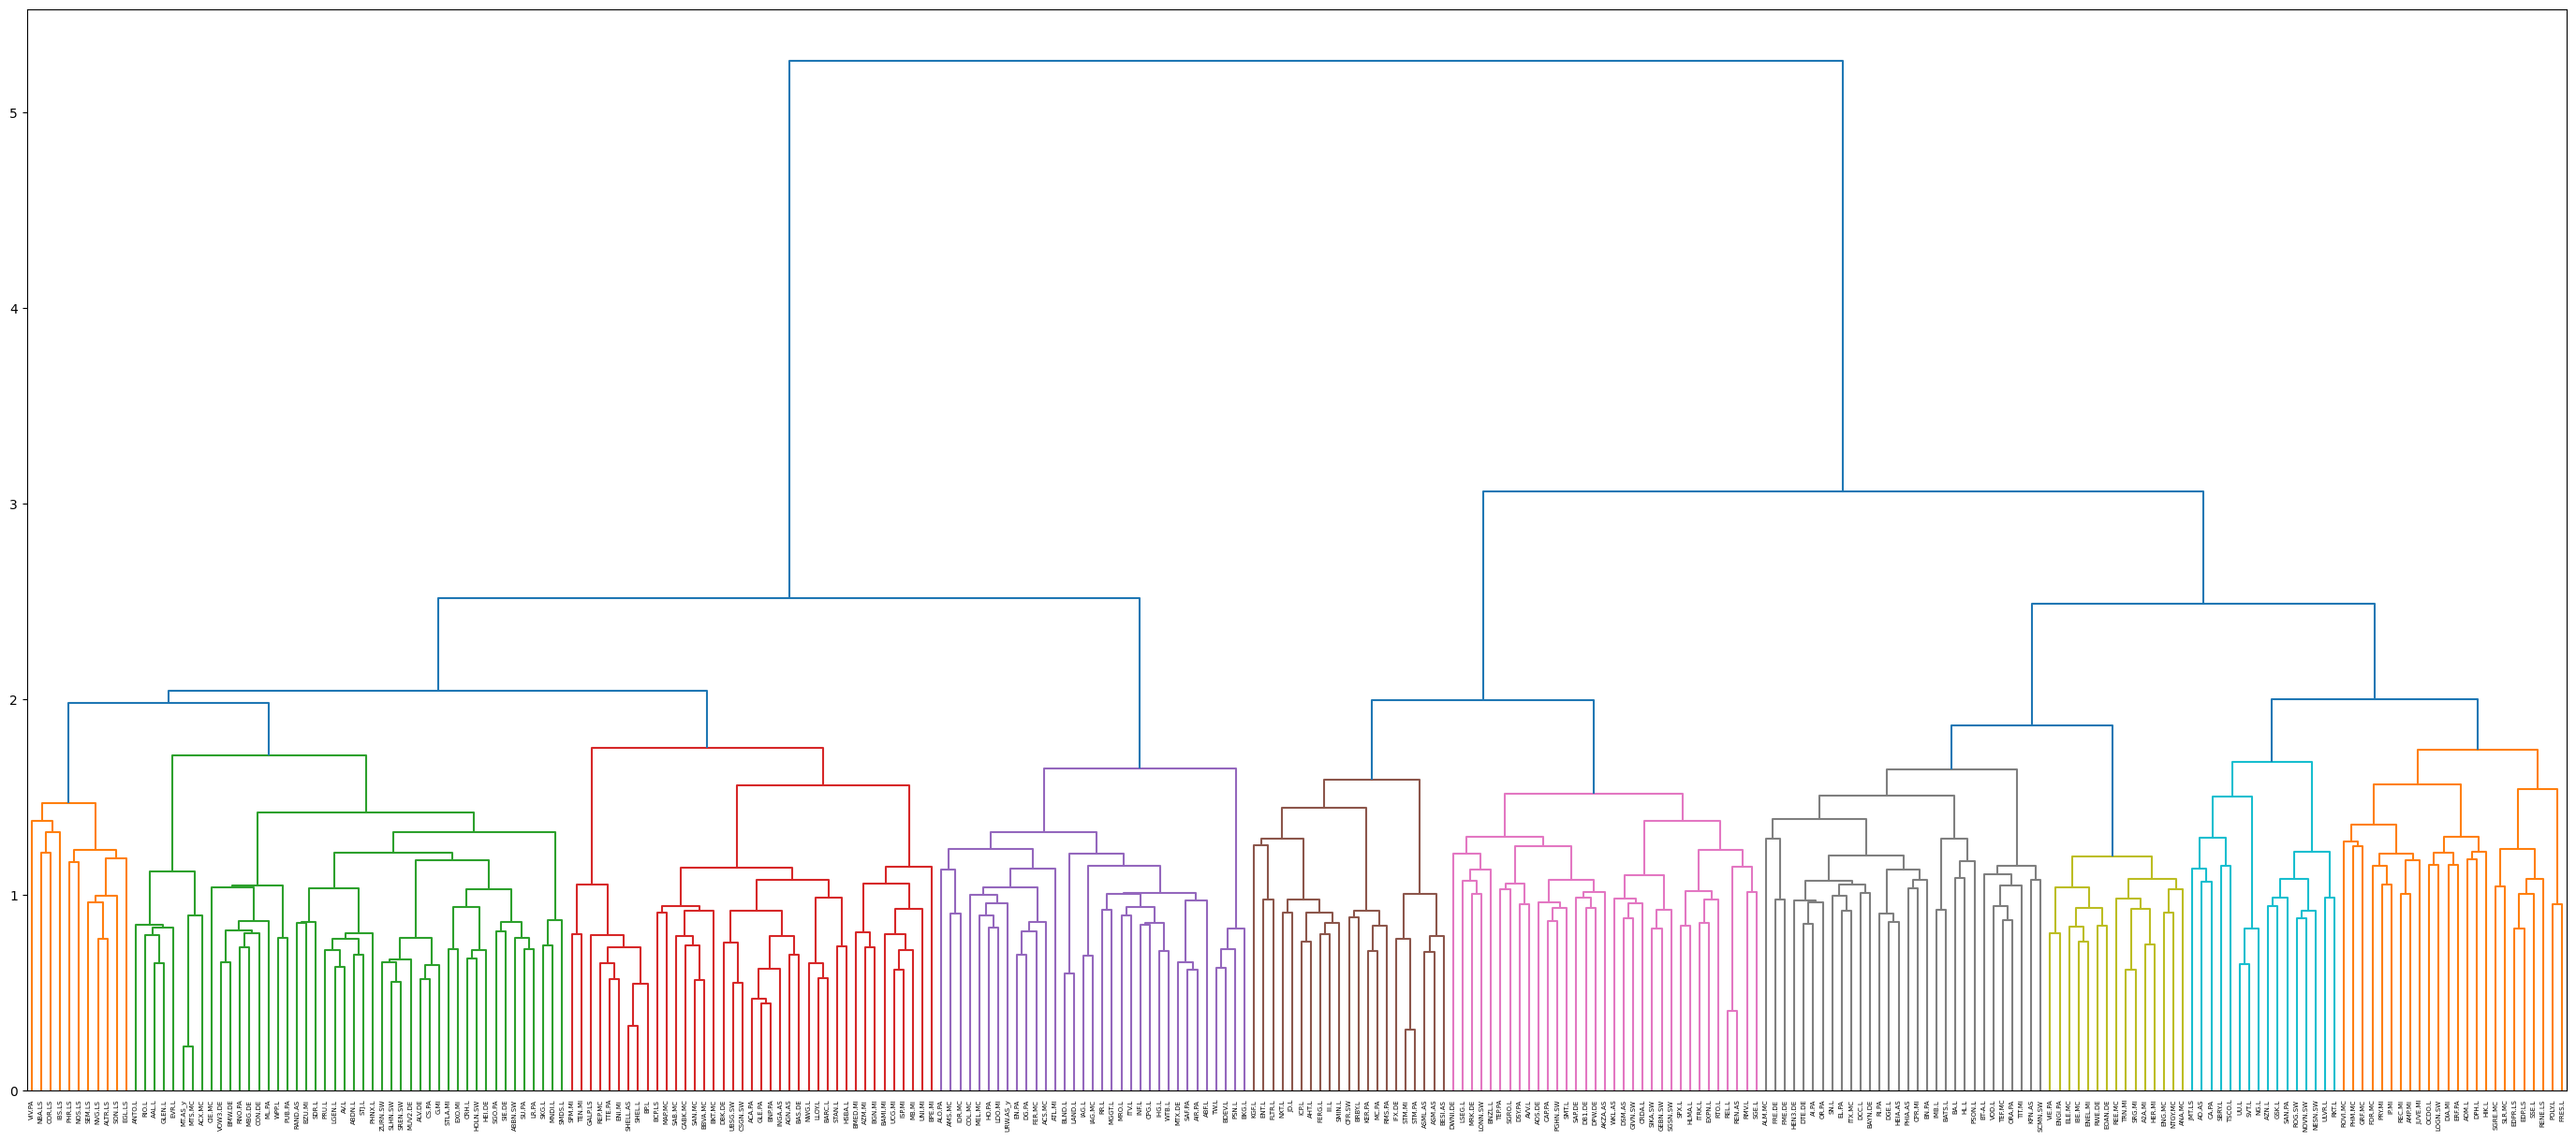

In [42]:
hacer_dendograma(ultima_ventana_european, rie_estimator.get_rie, 'ward', k_optimal_calenski_european_rie);

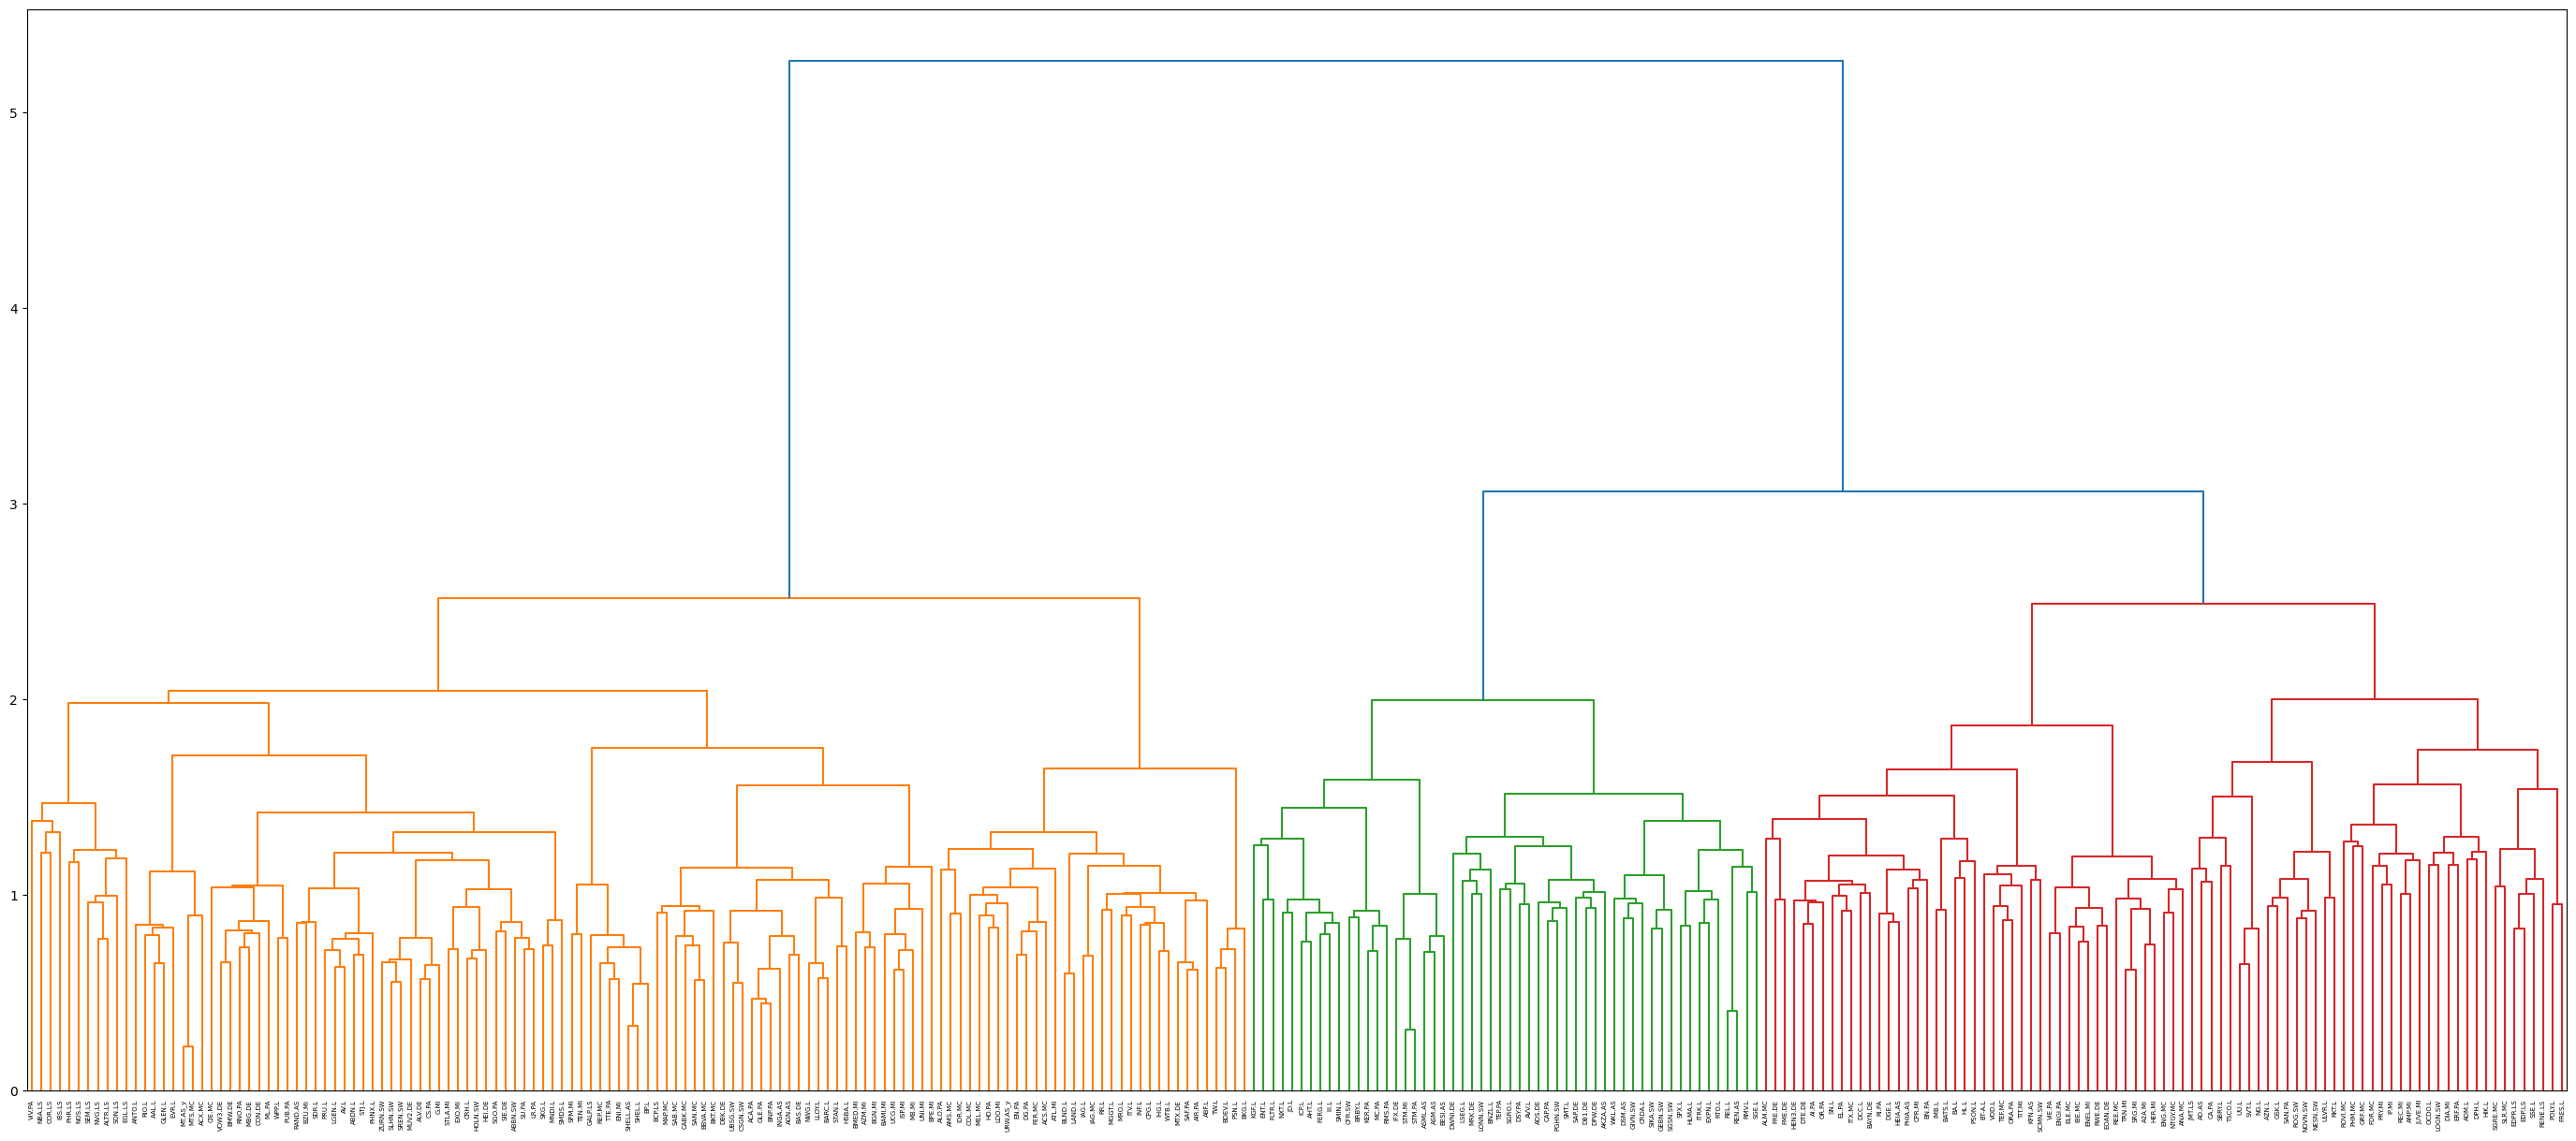

In [44]:
hacer_dendograma(ultima_ventana_european, rie_estimator.get_rie, 'ward', k_optimal_eigen_european_rie);

### ECA

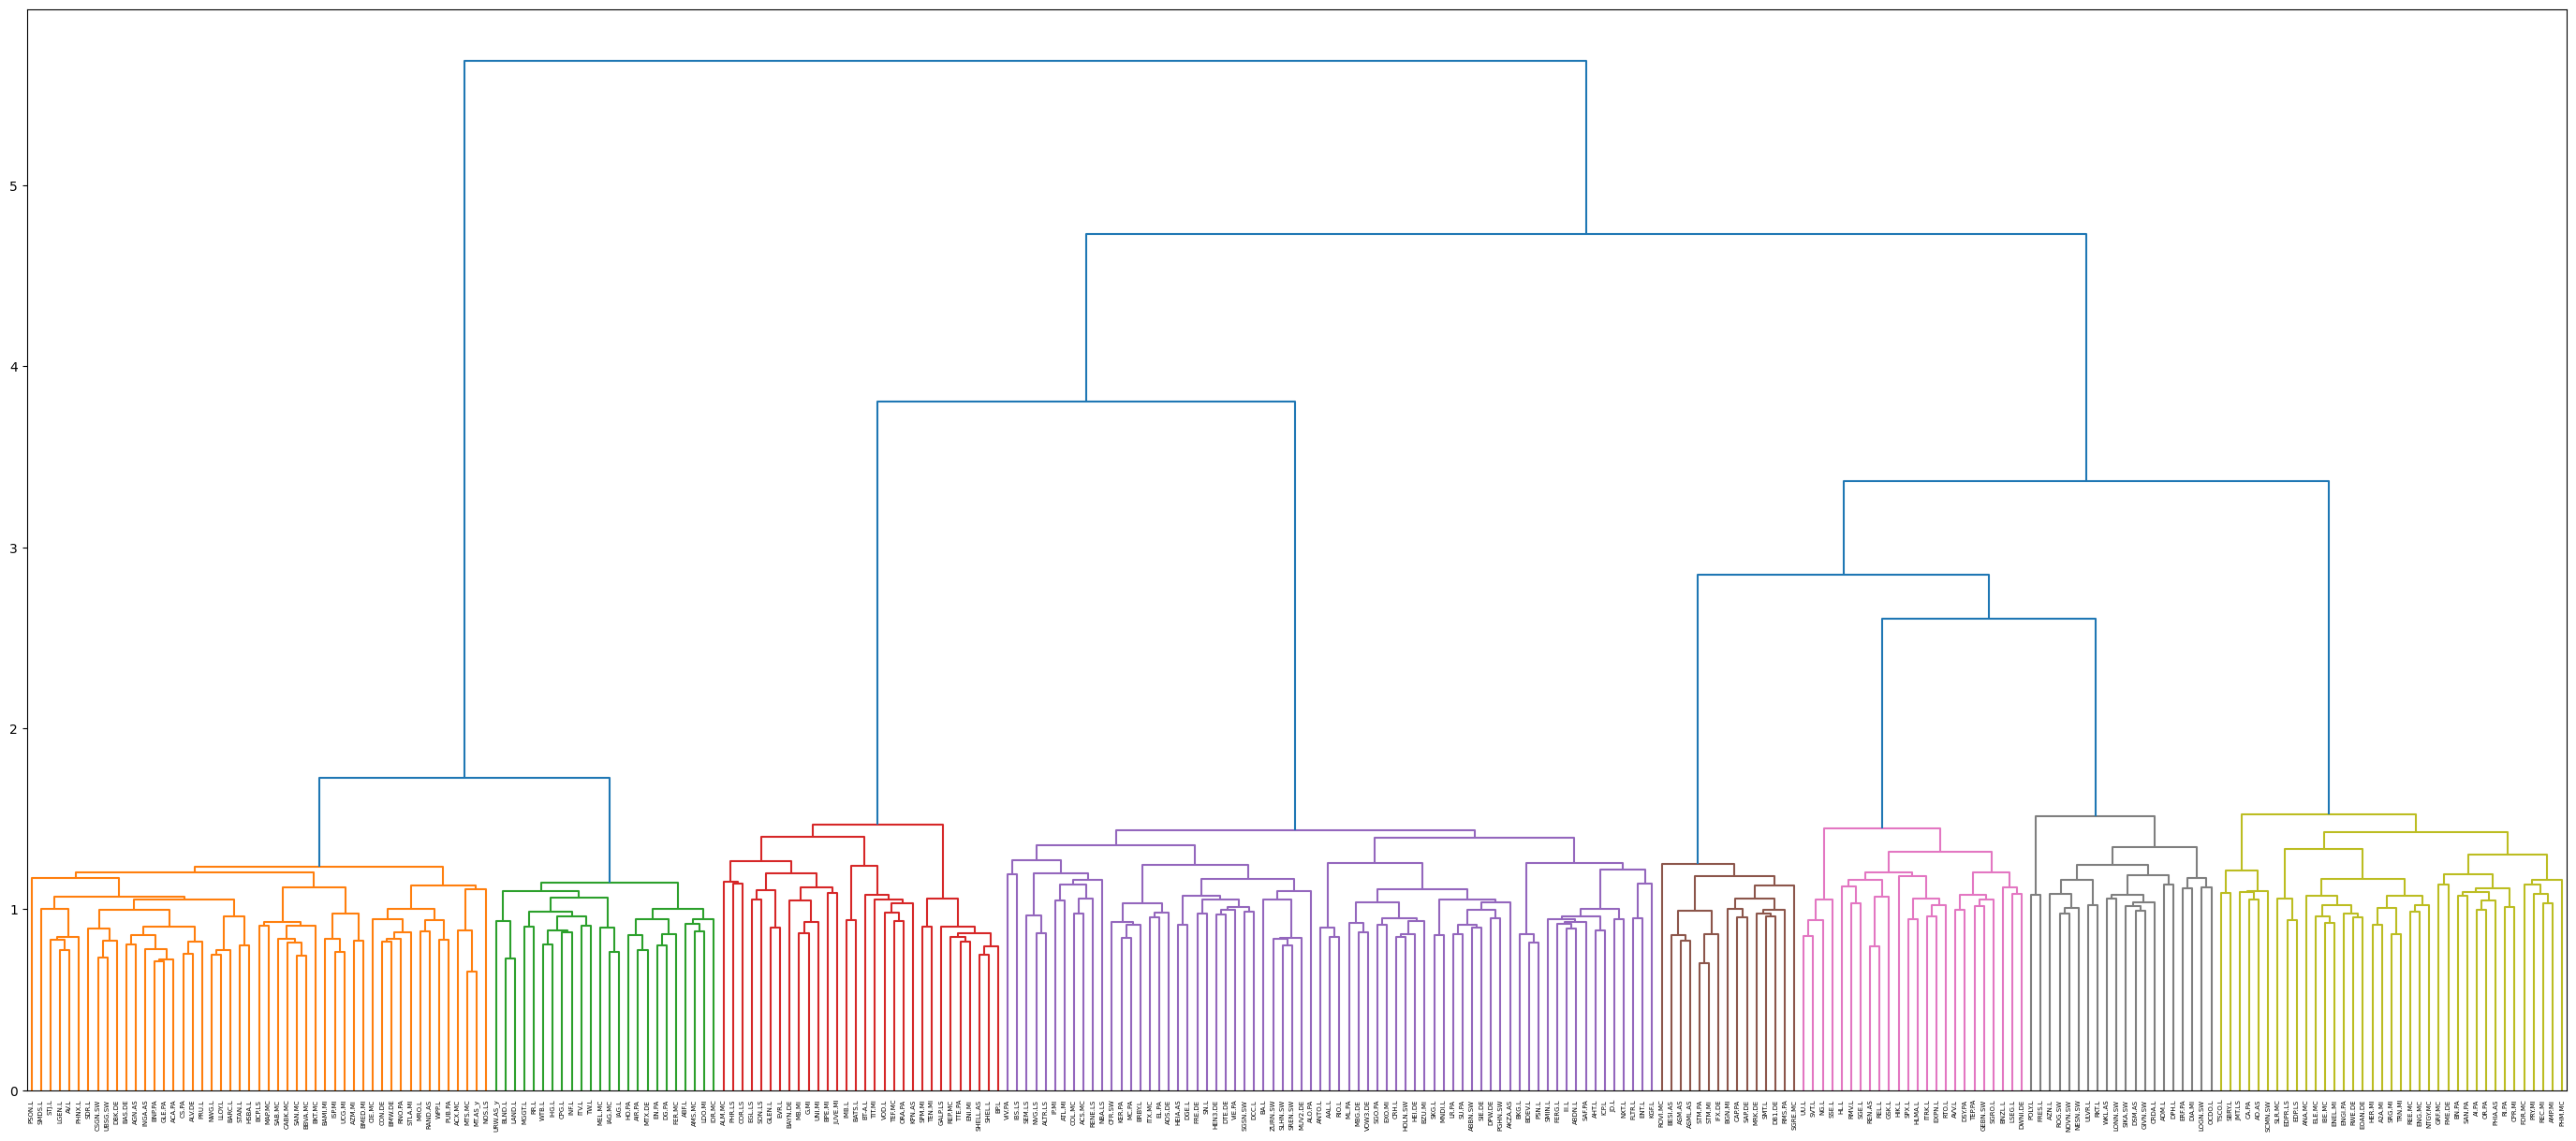

In [45]:
hacer_dendograma(ultima_ventana_european, wrapper_eca, 'ward', k_optimal_calenski_european_eca);

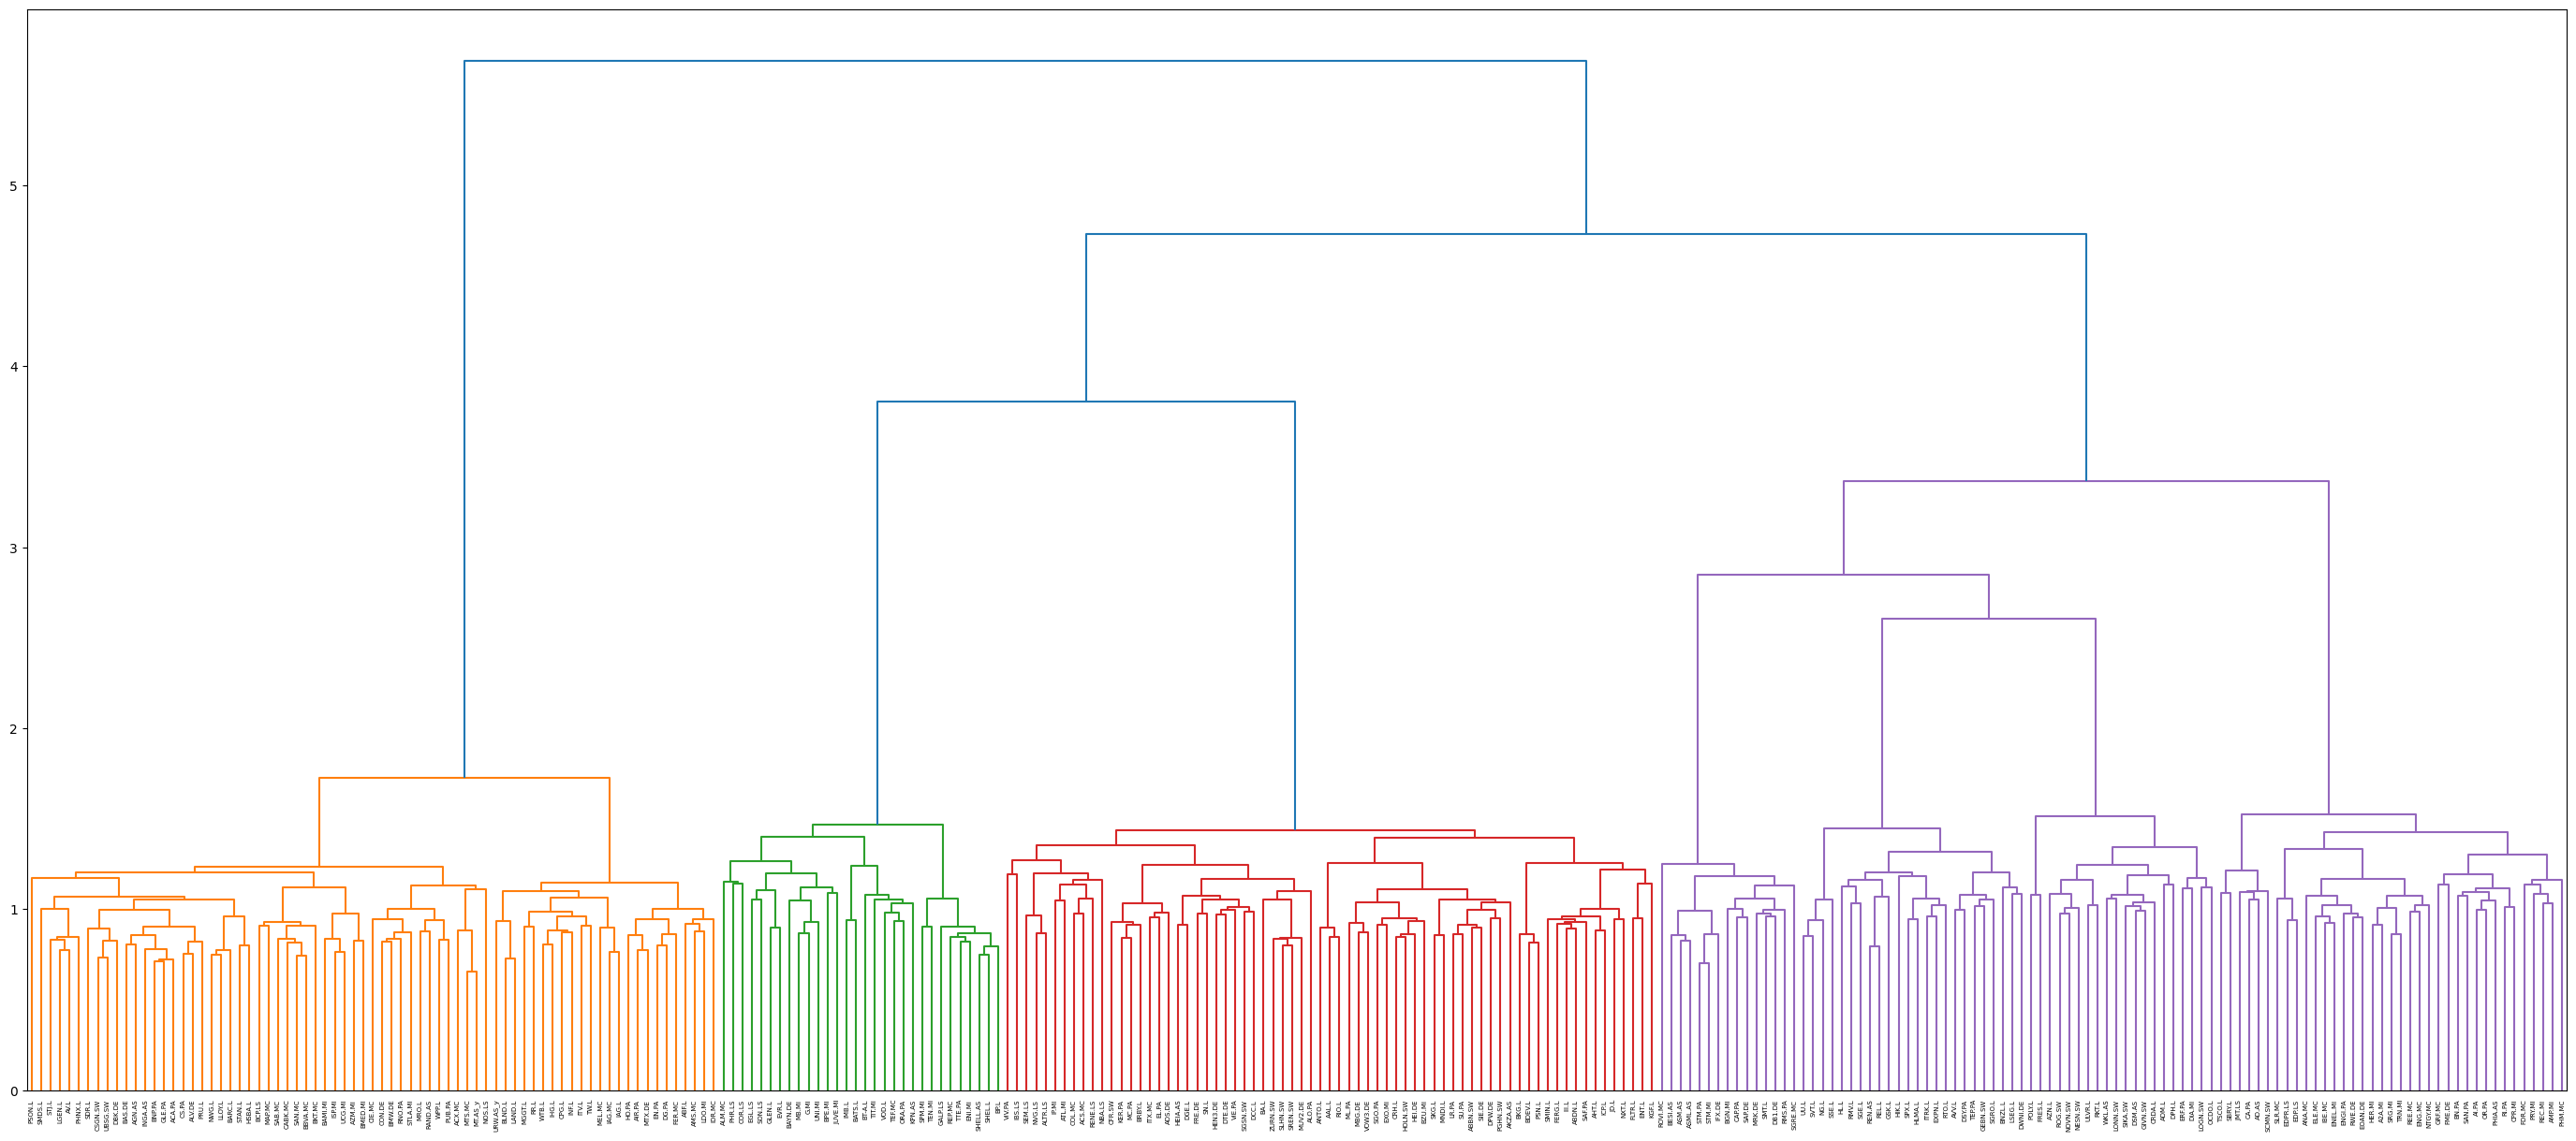

In [47]:
hacer_dendograma(ultima_ventana_european, wrapper_eca, 'ward', k_optimal_eigen_european_eca);

### PEARSON

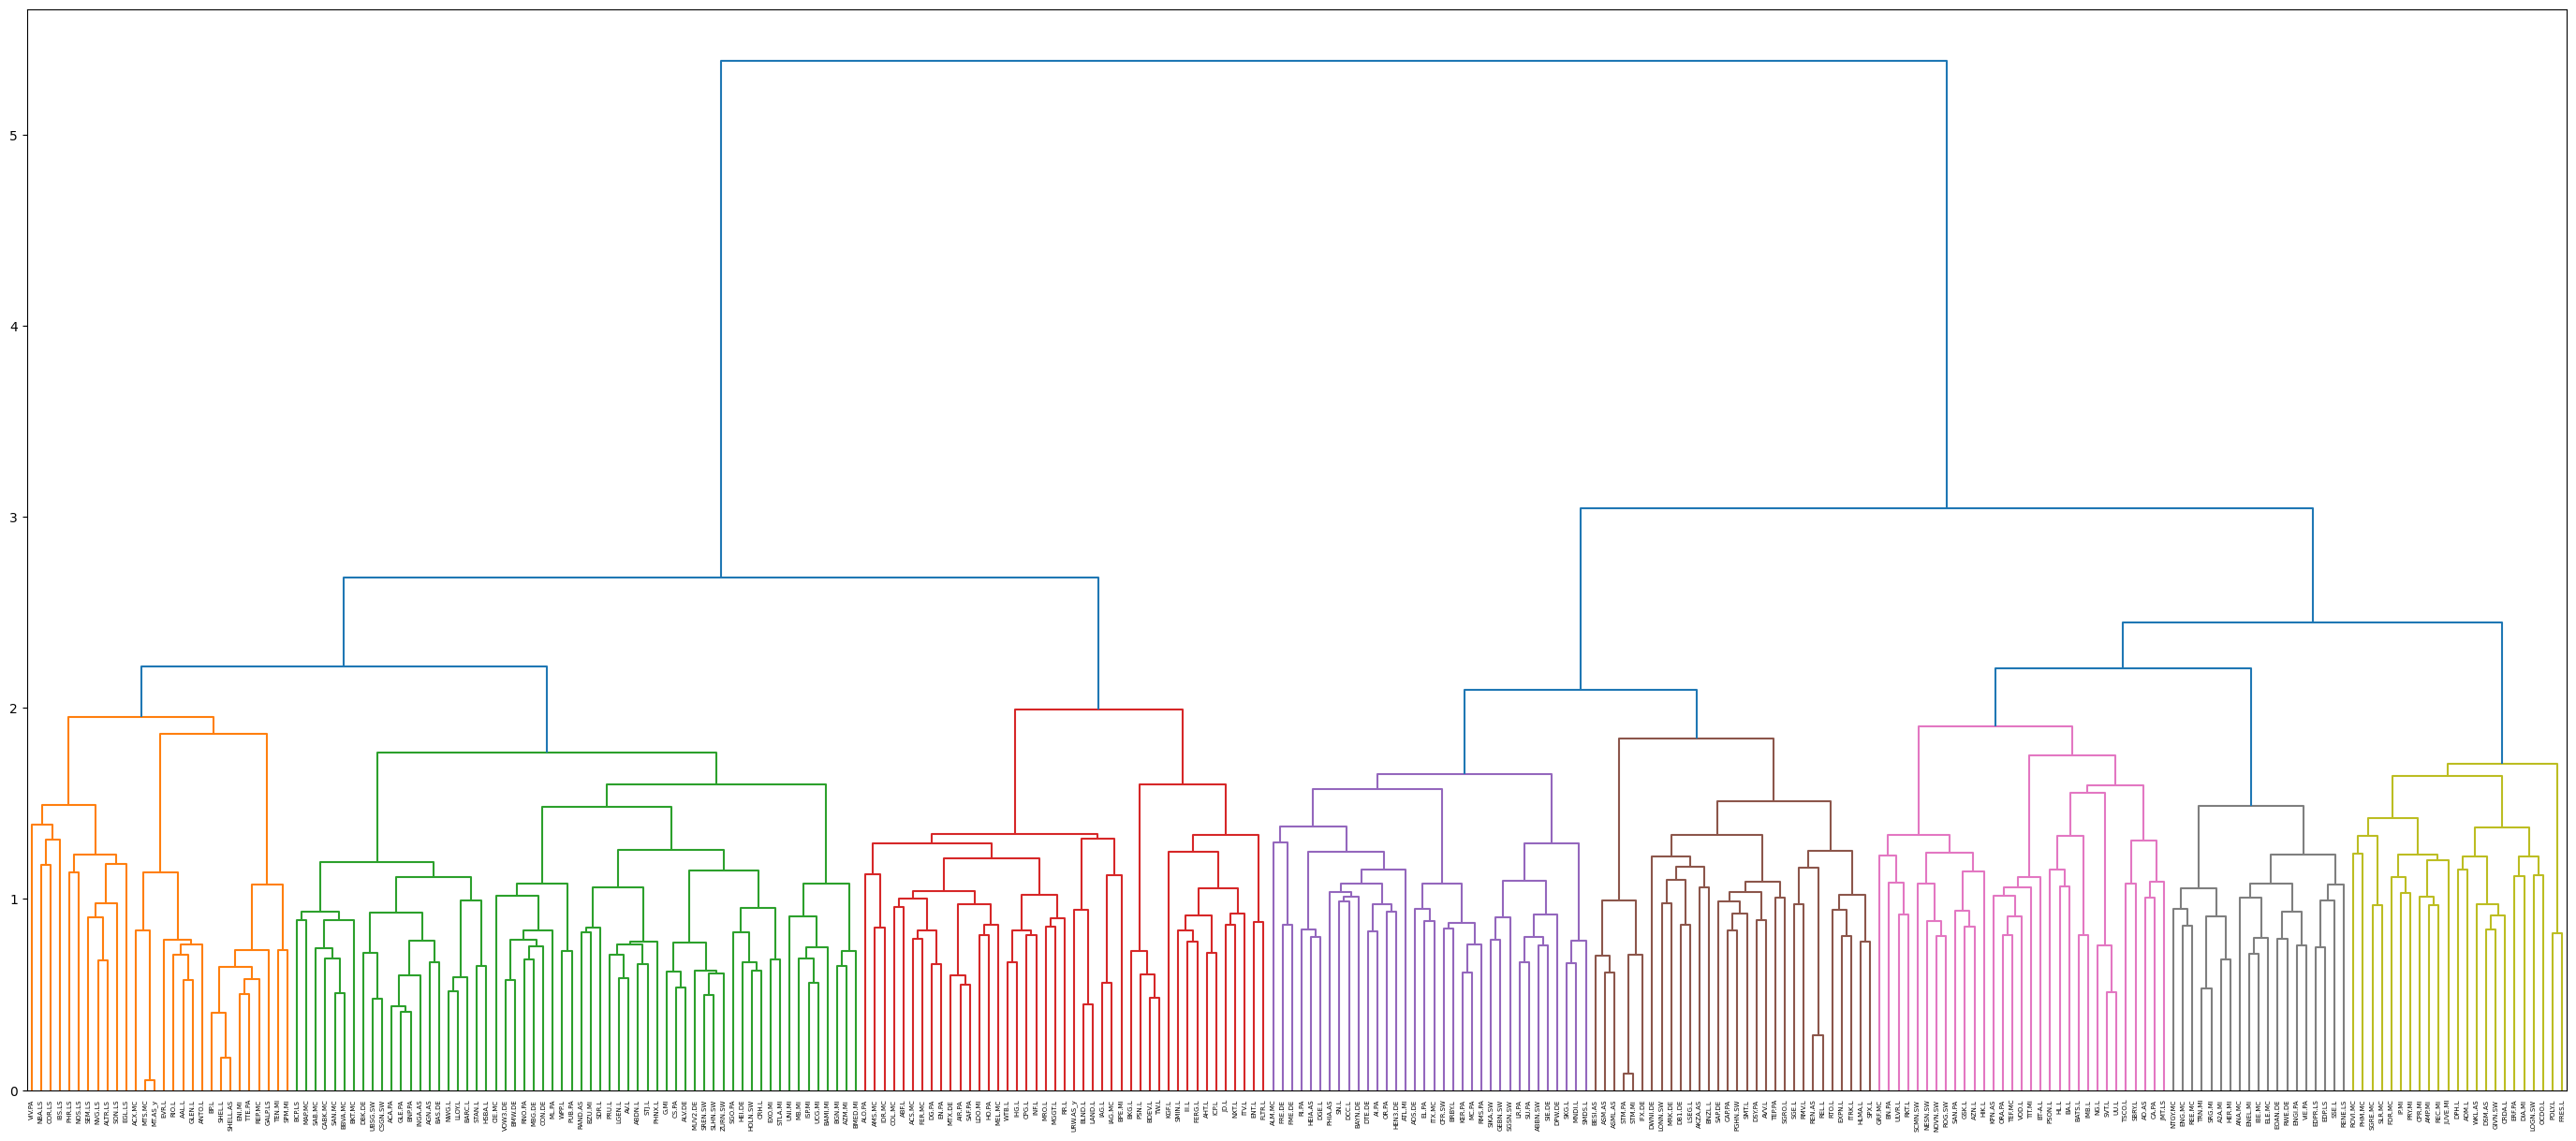

In [48]:
hacer_dendograma(ultima_ventana_european, wrapper_pearson, 'ward', k_optimal_calenski_european_pearson);

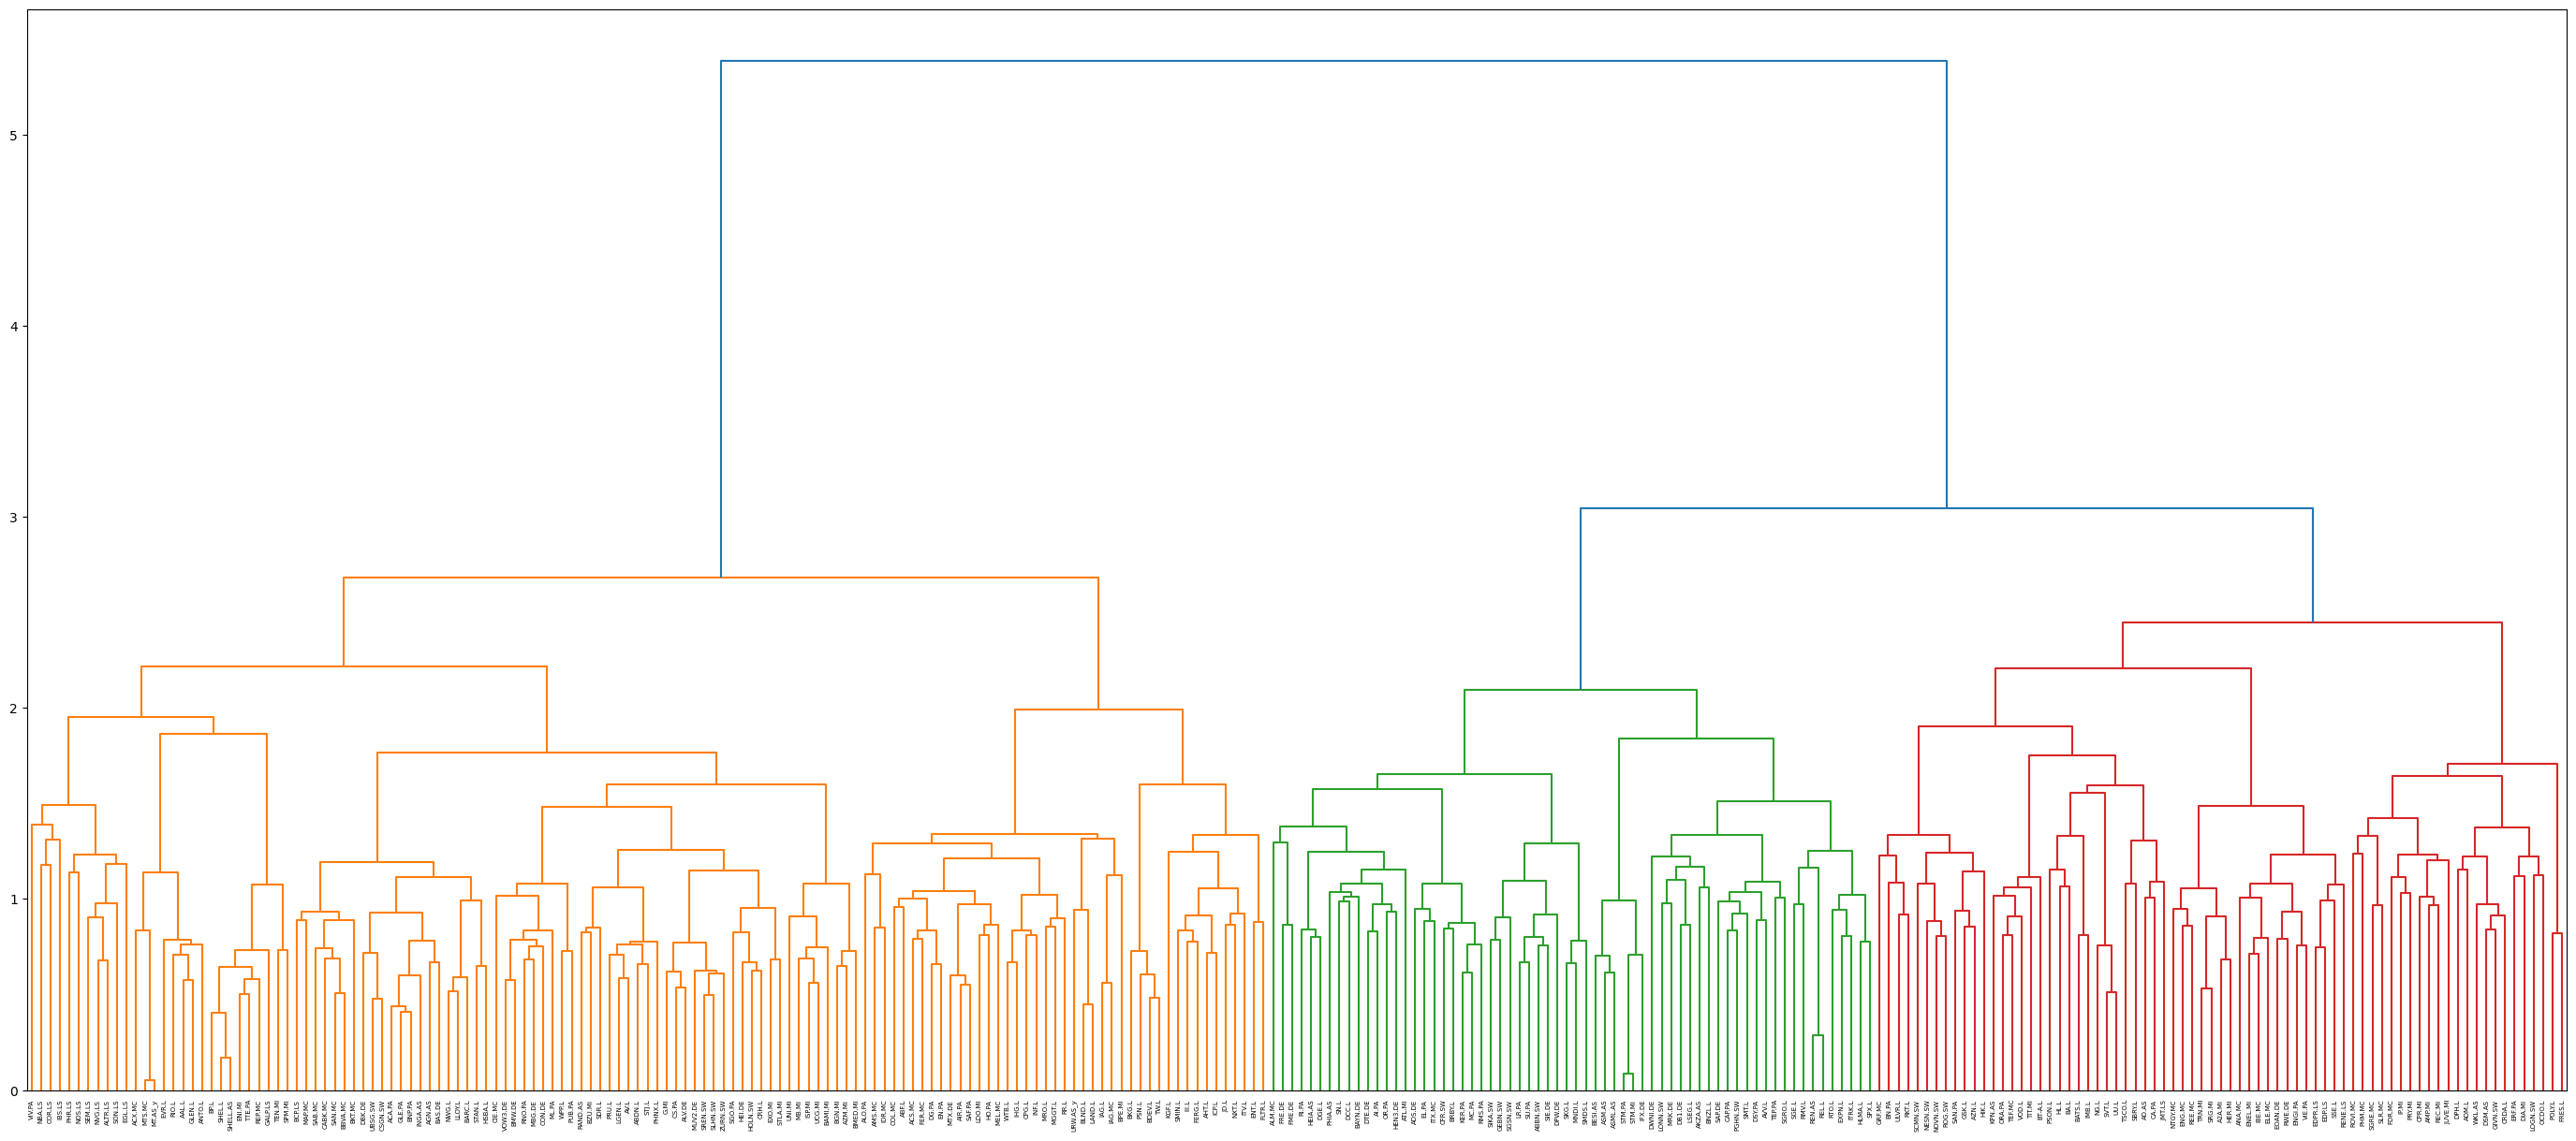

In [49]:
hacer_dendograma(ultima_ventana_european, wrapper_pearson, 'ward', k_optimal_eigen_european_pearson);

In [40]:
index, weights = hcaa_alocation(
    mat_X = ultima_ventana_american,
    n_clusters = k_optimal_calenski_american_rie,
    custom_corr=rie_estimator.get_rie,
    inverse_data=False,
)

## Getting the sector for each ticker

In [29]:
american_tickers = ultima_ventana_american.columns.to_numpy()
european_tickers = ultima_ventana_european.columns.to_numpy()

In [42]:
american_sectors = {}

In [44]:
for ticker in american_tickers:
    time.sleep(2)
    try :
        ticker_info = yfinance.Ticker(ticker).info
        american_sectors[ticker]=ticker_info['sector']    
    except:
        print('Something is wrong with the ticker ' + ticker)
        american_sectors[ticker]='NA'
    

Something is wrong with the ticker ABMD
Something is wrong with the ticker ANTM
Something is wrong with the ticker BLL
Something is wrong with the ticker CAT
Something is wrong with the ticker CERN
Something is wrong with the ticker CTXS
Something is wrong with the ticker DISCA
Something is wrong with the ticker DISCK
Something is wrong with the ticker DRE
Something is wrong with the ticker FBHS
Something is wrong with the ticker INFO
Something is wrong with the ticker NLOK
Something is wrong with the ticker NLSN
Something is wrong with the ticker PBCT
Something is wrong with the ticker SIVB
Something is wrong with the ticker VIAC
Something is wrong with the ticker WLTW
Something is wrong with the ticker XLNX


In [48]:
european_sectors = {}

In [49]:
for ticker in european_tickers:
    time.sleep(2)
    try :
        ticker_info = yfinance.Ticker(ticker).info
        european_sectors[ticker]=ticker_info['sector']    
    except:
        print('Something is wrong with the ticker: ' + ticker)
        european_sectors[ticker]='NA'
    

Something is wrong with the ticker: ML.PA
Something is wrong with the ticker: MT.AS_y
Something is wrong with the ticker: STM.PA
Something is wrong with the ticker: URW.AS_y
Something is wrong with the ticker: AVV.L
Something is wrong with the ticker: III.L
Something is wrong with the ticker: INF.L
Something is wrong with the ticker: MGGT.L
Something is wrong with the ticker: PSON.L
Something is wrong with the ticker: SMT.L
Something is wrong with the ticker: REE.MC
Something is wrong with the ticker: SGRE.MC
Something is wrong with the ticker: ATL.MI
Something is wrong with the ticker: EXO.MI
Something is wrong with the ticker: STLA.MI
Something is wrong with the ticker: STM.MI


In [52]:
serialized_sectors_american = pickle.dumps(american_sectors)

with open('serialized_sectors_american.pkl', 'wb') as file:
    file.write(serialized_sectors_american)

In [53]:
serialized_sectors_european = pickle.dumps(european_sectors)

with open('serialized_sectors_european.pkl', 'wb') as file:
    file.write(serialized_sectors_european)

### Lectura de los datos procesados para la lectura de los sectores

In [30]:
with open('serialized_sectors_european.pkl', 'rb') as file:
    serialized_data = file.read()

# Deserialize the object
european_sectors = pickle.loads(serialized_data)

# Print the deserialized object
print(len(european_sectors.keys()))

268


In [31]:
with open('serialized_sectors_american.pkl', 'rb') as file:
    serialized_data = file.read()

# Deserialize the object
american_sectors = pickle.loads(serialized_data)

# Print the deserialized object
print(len(american_sectors.keys()))

460


In [32]:
american_sectors_df = pd.DataFrame(data = american_sectors.values(), index = american_sectors.keys(), columns=['sector'])
european_sectors_df = pd.DataFrame(data = european_sectors.values(), index = european_sectors.keys(), columns=['sector'])

Los tickers para los que no se encontaron sus sectores se mencionan a continuación:

In [23]:
american_sectors_df[american_sectors_df.sector == 'NA']

,sector
ABMD,NA
ANTM,NA
BLL,NA
CAT,NA
CERN,NA
CTXS,NA
DISCA,NA
DISCK,NA
DRE,NA
FBHS,NA


In [24]:
european_sectors_df[european_sectors_df.sector == 'NA']

,sector
ML.PA,NA
MT.AS_y,NA
STM.PA,NA
URW.AS_y,NA
AVV.L,NA
III.L,NA
INF.L,NA
MGGT.L,NA
PSON.L,NA
SMT.L,NA


# Aplicación del HCAA

Aquí groupitos contiene el grupo al que pertenece cada índice

In [33]:
index, weights, groupitos = hcaa_alocation(
    mat_X = ultima_ventana_american,
    n_clusters = k_optimal_calenski_american_rie,
    custom_corr=rie_estimator.get_rie,
    inverse_data=False,
    return_groups=True
)

Me quedo creando un data frame vacío. A este dataframe es a donde se le va a meter las filas por cada grupo y después hacer las tablas de latex. 

In [44]:
def get_asignation_table(returns_matrix: pd.DataFrame, n_grupos:int,  custom_corr_func: t.Callable, inverse_data: bool, return_groups: bool)-> str:
    '''
    Función para obtener la distribución de los activos y su proporción entre los diferentes sectores financieros
    '''

    _, _, grupos = hcaa_alocation(
        mat_X = returns_matrix,
        n_clusters = n_grupos,
        custom_corr=custom_corr_func,
        inverse_data=inverse_data,
        return_groups=return_groups
    )
    sector_distribution_df = pd.DataFrame(columns =  list(american_sectors_df['sector'].unique()))
    for group_index, grupito in enumerate(grupos):
        american_sectors_df.loc[american_sectors_df.index[grupito], "grupo"] = int(group_index)
        selected_assets_sectors = american_sectors_df[american_sectors_df['grupo'] == group_index]['sector'].value_counts()
        sector_distribution_df.loc[len(sector_distribution_df)] = selected_assets_sectors
    sector_distribution_df.fillna(0, inplace=True)
    sector_distribution_df['suma_activos'] = sector_distribution_df.sum(axis = 1)
    sector_distribution_percentages_df = sector_distribution_df.div(sector_distribution_df['suma_activos'], axis=0) * 100
    sector_distribution_percentages_df.drop('suma_activos', axis = 1, inplace=True)
    sector_distribution_percentages_df.drop('NA', axis = 1, inplace=True)
    return sector_distribution_percentages_df.T.to_latex(header=True, float_format="%.2f")


In [47]:
american_calenski_rie = get_asignation_table(ultima_ventana_american, k_optimal_calenski_american_rie, rie_estimator.get_rie,False, True )
print(american_calenski_rie)

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 \\
\midrule
Healthcare & 0.00 & 0.00 & 62.50 & 0.00 & 0.00 & 8.51 & 0.00 & 0.00 & 21.28 & 86.67 & 0.00 & 15.38 & 0.00 & 0.00 \\
Industrials & 0.00 & 0.00 & 0.00 & 0.00 & 38.32 & 8.51 & 35.29 & 0.00 & 14.89 & 0.00 & 0.00 & 0.00 & 0.00 & 16.00 \\
Consumer Cyclical & 0.00 & 0.00 & 5.00 & 0.00 & 16.82 & 51.06 & 52.94 & 0.00 & 2.13 & 0.00 & 0.00 & 7.69 & 0.00 & 0.00 \\
Technology & 0.00 & 0.00 & 2.50 & 0.00 & 11.21 & 10.64 & 0.00 & 0.00 & 19.15 & 0.00 & 94.44 & 57.69 & 0.00 & 0.00 \\
Consumer Defensive & 0.00 & 0.00 & 15.00 & 0.00 & 4.67 & 4.26 & 0.00 & 0.00 & 2.13 & 0.00 & 0.00 & 0.00 & 100.00 & 36.00 \\
Utilities & 0.00 & 0.00 & 0.00 & 100.00 & 0.00 & 4.26 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
Financial Services & 95.92 & 0.00 & 0.00 & 0.00 & 0.93 & 0.00 & 0.00 & 0.00 & 34.04 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
Basic Materials & 0.00 & 0.00 & 2.50 & 0.00 & 14.02 & 

In [48]:
american_calenski_calenski = get_asignation_table(ultima_ventana_american, k_optimal_eigen_american_rie, rie_estimator.get_rie,False, True )
print(american_calenski_calenski)

\begin{tabular}{lrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 \\
\midrule
Healthcare & 0.00 & 2.33 & 47.06 & 9.09 & 0.00 & 0.00 \\
Industrials & 3.64 & 26.16 & 6.86 & 0.00 & 18.75 & 0.00 \\
Consumer Cyclical & 0.00 & 24.42 & 2.94 & 4.55 & 28.12 & 0.00 \\
Technology & 0.00 & 9.88 & 9.80 & 72.73 & 0.00 & 0.00 \\
Consumer Defensive & 17.27 & 4.07 & 6.86 & 0.00 & 0.00 & 0.00 \\
Utilities & 23.64 & 1.16 & 0.00 & 0.00 & 0.00 & 0.00 \\
Financial Services & 42.73 & 0.58 & 15.69 & 0.00 & 0.00 & 70.15 \\
Basic Materials & 0.00 & 10.47 & 0.98 & 0.00 & 0.00 & 0.00 \\
Real Estate & 8.18 & 1.74 & 0.00 & 0.00 & 50.00 & 0.00 \\
Energy & 0.00 & 11.05 & 0.00 & 0.00 & 0.00 & 26.87 \\
Communication Services & 1.82 & 4.65 & 2.94 & 9.09 & 3.12 & 0.00 \\
\bottomrule
\end{tabular}



In [49]:
american_calenski_calenski = get_asignation_table(ultima_ventana_american, k_optimal_calenski_american_eca, wrapper_eca,False, True )
print(american_calenski_calenski)

\begin{tabular}{lrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 \\
\midrule
Healthcare & 16.82 & 11.29 & 11.49 & 1.35 & 8.33 & 8.20 \\
Industrials & 4.67 & 19.76 & 8.05 & 10.81 & 39.58 & 36.07 \\
Consumer Cyclical & 0.00 & 18.95 & 14.94 & 18.92 & 29.17 & 13.11 \\
Technology & 0.00 & 22.98 & 4.60 & 1.35 & 8.33 & 18.03 \\
Consumer Defensive & 21.50 & 3.63 & 6.90 & 2.70 & 2.08 & 1.64 \\
Utilities & 24.30 & 0.81 & 0.00 & 1.35 & 0.00 & 1.64 \\
Financial Services & 3.74 & 4.03 & 33.33 & 27.03 & 4.17 & 4.92 \\
Basic Materials & 0.93 & 7.26 & 5.75 & 6.76 & 2.08 & 11.48 \\
Real Estate & 22.43 & 0.81 & 0.00 & 2.70 & 2.08 & 1.64 \\
Energy & 0.00 & 0.40 & 2.30 & 22.97 & 0.00 & 0.00 \\
Communication Services & 1.87 & 6.05 & 5.75 & 1.35 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



In [56]:
k_optimal_calenski_american_rie

14

In [50]:
american_calenski_calenski = get_asignation_table(ultima_ventana_american, k_optimal_calenski_american_pearson, wrapper_pearson,False, True )
print(american_calenski_calenski)

\begin{tabular}{lrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 \\
\midrule
Healthcare & 18.27 & 14.62 & 0.00 & 0.00 & 26.58 & 18.87 \\
Industrials & 0.96 & 20.38 & 0.00 & 19.35 & 1.27 & 13.21 \\
Consumer Cyclical & 0.00 & 18.08 & 0.00 & 25.81 & 5.06 & 3.77 \\
Technology & 0.00 & 21.54 & 0.00 & 0.00 & 40.51 & 18.87 \\
Consumer Defensive & 22.12 & 3.46 & 1.43 & 0.00 & 7.59 & 1.89 \\
Utilities & 25.00 & 0.77 & 0.00 & 0.00 & 0.00 & 0.00 \\
Financial Services & 3.85 & 3.46 & 68.57 & 0.00 & 2.53 & 30.19 \\
Basic Materials & 0.96 & 6.92 & 0.00 & 0.00 & 1.27 & 0.00 \\
Real Estate & 23.08 & 0.77 & 0.00 & 51.61 & 0.00 & 0.00 \\
Energy & 0.00 & 0.38 & 25.71 & 0.00 & 0.00 & 0.00 \\
Communication Services & 1.92 & 5.38 & 1.43 & 3.23 & 8.86 & 7.55 \\
\bottomrule
\end{tabular}



In [109]:
sector_distribution_df = pd.DataFrame(columns =  list(american_sectors_df['sector'].unique()))
for group_index, grupito in enumerate(groupitos):
    american_sectors_df.loc[american_sectors_df.index[grupito], "grupo"] = int(group_index)
    selected_assets_sectors = american_sectors_df[american_sectors_df['grupo'] == group_index]['sector'].value_counts()
    sector_distribution_df.loc[len(sector_distribution_df)] = selected_assets_sectors
sector_distribution_df.fillna(0, inplace=True)
sector_distribution_df['suma_activos'] = sector_distribution_df.sum(axis = 1)
sector_distribution_percentages_df = sector_distribution_df.div(sector_distribution_df['suma_activos'], axis=0) * 100
sector_distribution_percentages_df.drop('suma_activos', axis = 1, inplace=True)
sector_distribution_percentages_df.drop('NA', axis = 1, inplace=True)
#sector_distribution_percentages_df = sector_distribution_percentages_df.style.format(precision=2)


Esta sería la forma de pasar la tabla a latex. Ojo, aún hay que hacer un wrap de este output dentro de lo siguiente:

\\begin{table}[hbt]
\tiny
\centering
 OUTPUT QUE SE OBTIENE
\\end{table}

Esto para que todo encaje dentro de una página. 

**ME QUEDO PASANDO TODO ESTE CÓDIGO A UNA FUNCIÓN PARA PODER LLAMAR LA FUNCIÓN PARA CADA UNO DE LOS SEIS PORTAFOLIOS POR CADA MERCADO QUE SE TIENEN QUE HACER**

In [119]:
print(sector_distribution_percentages_df.T.to_latex(header=True, float_format="%.2f"))

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 \\
\midrule
Healthcare & 0.00 & 0.00 & 62.50 & 0.00 & 0.00 & 8.51 & 0.00 & 0.00 & 21.28 & 86.67 & 0.00 & 15.38 & 0.00 & 0.00 \\
Industrials & 0.00 & 0.00 & 0.00 & 0.00 & 38.32 & 8.51 & 35.29 & 0.00 & 14.89 & 0.00 & 0.00 & 0.00 & 0.00 & 16.00 \\
Consumer Cyclical & 0.00 & 0.00 & 5.00 & 0.00 & 16.82 & 51.06 & 52.94 & 0.00 & 2.13 & 0.00 & 0.00 & 7.69 & 0.00 & 0.00 \\
Technology & 0.00 & 0.00 & 2.50 & 0.00 & 11.21 & 10.64 & 0.00 & 0.00 & 19.15 & 0.00 & 94.44 & 57.69 & 0.00 & 0.00 \\
Consumer Defensive & 0.00 & 0.00 & 15.00 & 0.00 & 4.67 & 4.26 & 0.00 & 0.00 & 2.13 & 0.00 & 0.00 & 0.00 & 100.00 & 36.00 \\
Utilities & 0.00 & 0.00 & 0.00 & 100.00 & 0.00 & 4.26 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
Financial Services & 95.92 & 0.00 & 0.00 & 0.00 & 0.93 & 0.00 & 0.00 & 0.00 & 34.04 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
Basic Materials & 0.00 & 0.00 & 2.50 & 0.00 & 14.02 & 

In [118]:
print(sector_distribution_percentages_df.T.to_latex(header=True, float_format="%.2f", column_format='lp{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}'))

\begin{tabular}{lp{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 \\
\midrule
Healthcare & 0.00 & 0.00 & 62.50 & 0.00 & 0.00 & 8.51 & 0.00 & 0.00 & 21.28 & 86.67 & 0.00 & 15.38 & 0.00 & 0.00 \\
Industrials & 0.00 & 0.00 & 0.00 & 0.00 & 38.32 & 8.51 & 35.29 & 0.00 & 14.89 & 0.00 & 0.00 & 0.00 & 0.00 & 16.00 \\
Consumer Cyclical & 0.00 & 0.00 & 5.00 & 0.00 & 16.82 & 51.06 & 52.94 & 0.00 & 2.13 & 0.00 & 0.00 & 7.69 & 0.00 & 0.00 \\
Technology & 0.00 & 0.00 & 2.50 & 0.00 & 11.21 & 10.64 & 0.00 & 0.00 & 19.15 & 0.00 & 94.44 & 57.69 & 0.00 & 0.00 \\
Consumer Defensive & 0.00 & 0.00 & 15.00 & 0.00 & 4.67 & 4.26 & 0.00 & 0.00 & 2.13 & 0.00 & 0.00 & 0.00 & 100.00 & 36.00 \\
Utilities & 0.00 & 0.00 & 0.00 & 100.00 & 0.00 & 4.26 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
Financial Services & 95.92 & 0.00 & 0.00 & 0.00 & 0.93 & 0.00 & 0.00 & 0.00 & 34.04 & 0.00 & 0.00 & 0.

In [97]:
print(sector_distribution_percentages_df.to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & Healthcare & Industrials & Consumer Cyclical & Technology & Consumer Defensive & Utilities & Financial Services & Basic Materials & Real Estate & Energy & Communication Services \\
\midrule
0 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 95.920000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
1 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 100.000000 & 0.000000 \\
2 & 62.500000 & 0.000000 & 5.000000 & 2.500000 & 15.000000 & 0.000000 & 0.000000 & 2.500000 & 0.000000 & 0.000000 & 7.500000 \\
3 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 100.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
4 & 0.000000 & 38.320000 & 16.820000 & 11.210000 & 4.670000 & 0.000000 & 0.930000 & 14.020000 & 2.800000 & 0.930000 & 5.610000 \\
5 & 8.510000 & 8.510000 & 51.060000 & 10.640000 & 4.260000 & 4.260000 & 0.000000 & 6.380000 & 0.000000 & 0.000000 & 4.260000 \\

In [72]:
sector_distribution_percentages_df

,Healthcare,Industrials,Consumer Cyclical,Technology,NA,Consumer Defensive,Utilities,Financial Services,Basic Materials,Real Estate,Energy,Communication Services,suma_activos
0,0.000000,0.000000,0.000000,0.000000,0.291545,0.000000,0.000000,6.851312,0.000000,0.000000,0.000000,0.000000,100.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.692308,0.000000,100.0
2,5.208333,0.000000,0.416667,0.208333,0.416667,1.250000,0.000000,0.000000,0.208333,0.000000,0.000000,0.625000,100.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.090909,0.000000,0.000000,0.000000,0.000000,0.000000,100.0
4,0.000000,3.831776,1.682243,1.121495,0.467290,0.467290,0.000000,0.093458,1.401869,0.280374,0.093458,0.560748,100.0
5,0.945626,0.945626,5.673759,1.182033,0.236407,0.472813,0.472813,0.000000,0.709220,0.000000,0.000000,0.472813,100.0
6,0.000000,4.411765,6.617647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.735294,0.000000,0.735294,100.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.285714,0.000000,0.000000,100.0
8,3.546099,2.482270,0.354610,3.191489,1.063830,0.354610,0.000000,5.673759,0.000000,0.000000,0.000000,0.000000,100.0
9,17.333333,0.000000,0.000000,0.000000,2.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0


In [67]:
sector_distribution_df

,Healthcare,Industrials,Consumer Cyclical,Technology,NA,Consumer Defensive,Utilities,Financial Services,Basic Materials,Real Estate,Energy,Communication Services,suma_activos
0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,49.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,18.0
2,25.0,0.0,2.0,1.0,2.0,6.0,0.0,0.0,1.0,0.0,0.0,3.0,40.0
3,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,26.0
4,0.0,41.0,18.0,12.0,5.0,5.0,0.0,1.0,15.0,3.0,1.0,6.0,107.0
5,4.0,4.0,24.0,5.0,1.0,2.0,2.0,0.0,3.0,0.0,0.0,2.0,47.0
6,0.0,6.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,17.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,15.0
8,10.0,7.0,1.0,9.0,3.0,1.0,0.0,16.0,0.0,0.0,0.0,0.0,47.0
9,13.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
